# 0. install & Import & Constant

In [1]:
# pip install pyarrow

In [2]:
# unix time: https://www.unixtimestamp.com/
import datetime  # Convert to unix time
import math
import os
import pickle
import time  # Convert to unix time
import warnings

import dask.dataframe as dd  # similar to pandas
import matplotlib.pylab as plt
# if numpy is not installed already : pip3 install numpy
import numpy as np  # Do aritmetic operations on arrays
import pandas as pd  # pandas to create small dataframes
import seaborn as sns  # Plots
# to install xgboost: pip3 install xgboost
# if it didnt happen check install_xgboost.JPG
import xgboost as xgb
from matplotlib import rcParams  # Size of plots
from sklearn.cluster import KMeans, MiniBatchKMeans  # Clustering
# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error, r2_score)

warnings.filterwarnings("ignore")

In [3]:
base_year = 2019
base_month_count = 1

# 1. Data Load

In [126]:
df = pd.read_parquet(f'yellow_tripdata_{base_year}-01.parquet', engine='pyarrow') 
taxi_zone_df = pd.read_csv('taxi_zone_lookup.csv')

In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,None
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,None
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN,None
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN,None


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7696617 entries, 0 to 7696616
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [7]:
df.isna().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count            28672
trip_distance                  0
RatecodeID                 28672
store_and_fwd_flag         28672
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     4884887
airport_fee              7696617
dtype: int64

In [8]:
taxi_zone_df.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [9]:
taxi_zone_df.shape

(265, 4)

In [10]:
pd.unique(taxi_zone_df['Borough'])

array(['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn',
       'Unknown'], dtype=object)

# 2. preprocess & visualization

In [11]:
# df=df.query("tpep_pickup_datetime >= '2019-01-01' and tpep_pickup_datetime <='2019-12-31'")
# df=df.query("tpep_dropoff_datetime >= '2019-01-01' and tpep_dropoff_datetime <='2019-12-31'")
# df=df.query("tpep_pickup_datetime >= '2020-01-01' and tpep_pickup_datetime <='2020-12-31'")
# df=df.query("tpep_dropoff_datetime >= '2020-01-01' and tpep_dropoff_datetime <='2020-12-31'")

In [12]:
df.shape

(7696617, 19)

## 2-0. Select region

In [13]:
region = "Manhattan"

In [14]:
nyc_region = taxi_zone_df[taxi_zone_df['Borough'] == region]
nyc_region_number = nyc_region['LocationID']

In [15]:
nyc_regions_cnt = len(nyc_region)
print(nyc_regions_cnt)

69


In [16]:
nyc_region_arr_data = []
for i in nyc_region_number.values:
    nyc_region_arr_data.append(df[df['PULocationID'] == i])

In [17]:
nyc_region_df = pd.concat(nyc_region_arr_data, axis=0, ignore_index=True)

In [18]:
nyc_region_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:10:52,2019-01-01 00:51:27,1.0,3.8,1.0,N,4,246,2,25.0,0.5,0.5,0.00,0.0,0.3,26.30,NaN,None
1,1,2019-01-01 00:14:58,2019-01-01 00:24:33,1.0,2.7,1.0,N,4,87,1,11.0,0.5,0.5,1.00,0.0,0.3,13.30,NaN,None
2,1,2019-01-01 00:27:31,2019-01-01 00:36:35,1.0,2.3,1.0,N,4,233,1,8.5,0.5,0.5,1.95,0.0,0.3,11.75,NaN,None
3,1,2019-01-01 00:17:29,2019-01-01 00:31:23,1.0,4.7,1.0,N,4,263,1,15.5,0.5,0.5,3.35,0.0,0.3,20.15,NaN,None
4,1,2019-01-01 00:47:10,2019-01-01 00:56:31,1.0,3.9,1.0,N,4,261,1,13.0,0.5,0.5,2.85,0.0,0.3,17.15,NaN,None


In [19]:
nyc_region_df.shape

(6950965, 19)

## 2-1. Trip Durations

In [20]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    s = np.datetime_as_string(s, unit='s')
    s = s.replace('T', ' ')
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())




# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']]
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','PULocationID','DOLocationID','total_amount']]
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(nyc_region_df)
print(frame_with_durations.head())

   passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              1.0            3.8             4           246         26.30   
1              1.0            2.7             4            87         13.30   
2              1.0            2.3             4           233         11.75   
3              1.0            4.7             4           263         20.15   
4              1.0            3.9             4           261         17.15   

   trip_times  pickup_times      Speed  
0   40.583333  1.546269e+09   5.618070  
1    9.583333  1.546269e+09  16.904348  
2    9.066667  1.546270e+09  15.220588  
3   13.900000  1.546269e+09  20.287770  
4    9.350000  1.546271e+09  25.026738  


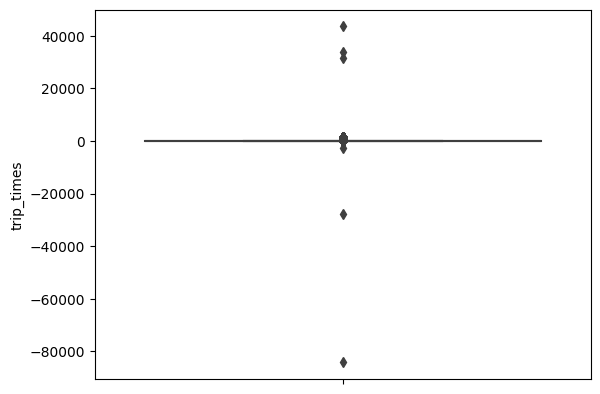

In [21]:
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [22]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -84280.5
10 percentile value is 3.7666666666666666
20 percentile value is 5.25
30 percentile value is 6.65
40 percentile value is 8.1
50 percentile value is 9.716666666666667
60 percentile value is 11.583333333333334
70 percentile value is 13.9
80 percentile value is 17.083333333333332
90 percentile value is 22.483333333333334
100 percentile value is  43648.01666666667


In [23]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 22.483333333333334
91 percentile value is 23.316666666666666
92 percentile value is 24.25
93 percentile value is 25.316666666666666
94 percentile value is 26.55
95 percentile value is 28.05
96 percentile value is 29.966666666666665
97 percentile value is 32.53333333333333
98 percentile value is 36.583333333333336
99 percentile value is 45.38333333333333
100 percentile value is  43648.01666666667


In [24]:
# 99 percentile value
trip_times_diffusion = var[int(len(var)*(float(99)/100))]

for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    tmp = var[int(len(var)*(float(99+i)/100))]
    if trip_times_diffusion * 10 < tmp:
        trip_times_diffusion = var[int(len(var)*(float(99+i-0.1)/100))] * 2
        print(f"{99+i} percentile is diffusion value. So we set outline value {99+i-0.1} percentile value X 2: {trip_times_diffusion}")
        break
    print("{} percentile value is {}".format(99+i,tmp))
print("100 percentile value is ",var[-1])

99.0 percentile value is 45.38333333333333
99.1 percentile value is 47.0
99.2 percentile value is 48.93333333333333
99.3 percentile value is 51.2
99.4 percentile value is 54.2
99.5 percentile value is 58.166666666666664
99.6 percentile value is 64.11666666666666
99.7 percentile value is 77.18333333333334
99.8 percentile is diffusion value. So we set outline value 99.7 percentile value X 2: 154.36666666666667
100 percentile value is  43648.01666666667


In [25]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<trip_times_diffusion)]

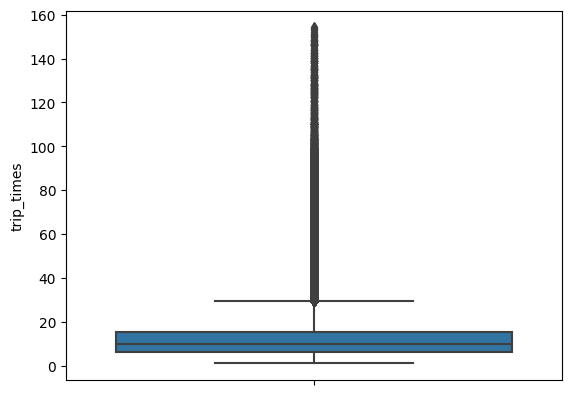

In [26]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

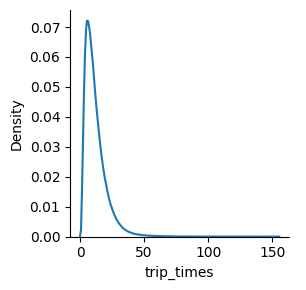

In [27]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified).map(sns.kdeplot,"trip_times").add_legend()
plt.show()

In [28]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

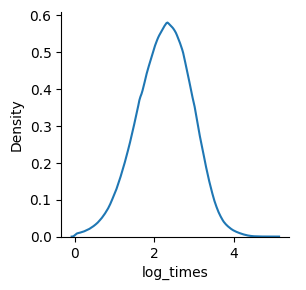

In [29]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified) \
      .map(sns.kdeplot,"log_times") \
      .add_legend()
plt.show()


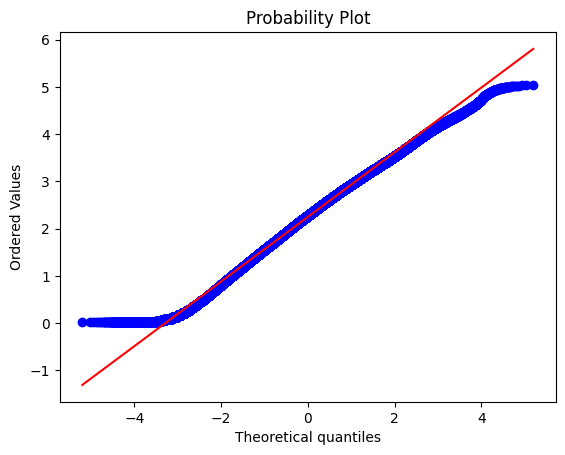

In [30]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

`scipy.stats.probplot`은 데이터의 분포도를 나타낸다.

## 2-2. Speed

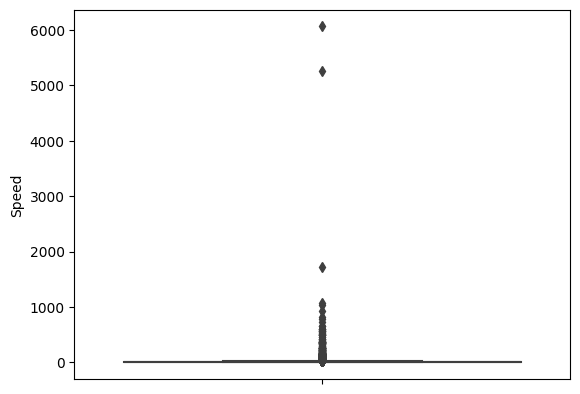

In [31]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [32]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 5.752330226364847
20 percentile value is 6.987778576563624
30 percentile value is 7.9644128113879
40 percentile value is 8.873949579831933
50 percentile value is 9.810526315789474
60 percentile value is 10.855313700384123
70 percentile value is 12.134831460674157
80 percentile value is 13.922651933701657
90 percentile value is 17.162790697674417
100 percentile value is  6063.75


In [33]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 17.162790697674417
91 percentile value is 17.68754716981132
92 percentile value is 18.28049435787211
93 percentile value is 18.958579881656807
94 percentile value is 19.761336515513126
95 percentile value is 20.727272727272727
96 percentile value is 21.934041363890444
97 percentile value is 23.478260869565222
98 percentile value is 25.653206650831354
99 percentile value is 29.425858290723152
100 percentile value is  6063.75


In [34]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    if i == 0.9:
        speed_99_9 = var[int(len(var)*(float(99+i)/100))]
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 29.425858290723152
99.1 percentile value is 30.0
99.2 percentile value is 30.62835959221501
99.3 percentile value is 31.35483870967742
99.4 percentile value is 32.165308498253786
99.5 percentile value is 33.108716944172386
99.6 percentile value is 34.236311239193085
99.7 percentile value is 35.62123385939742
99.8 percentile value is 37.49713849675697
99.9 percentile value is 40.34553775743707
100 percentile value is  6063.75


In [35]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<=speed_99_9)]

In [36]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

10.826119737873555

## 2-3. Trip Distance

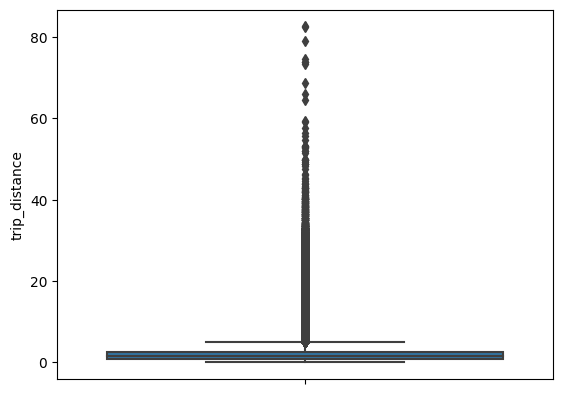

In [37]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [38]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.6
20 percentile value is 0.8
30 percentile value is 1.0
40 percentile value is 1.2
50 percentile value is 1.47
60 percentile value is 1.78
70 percentile value is 2.2
80 percentile value is 2.89
90 percentile value is 4.48
100 percentile value is  82.65


In [39]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 4.48
91 percentile value is 4.78
92 percentile value is 5.1
93 percentile value is 5.5
94 percentile value is 6.0
95 percentile value is 6.63
96 percentile value is 7.49
97 percentile value is 8.74
98 percentile value is 10.38
99 percentile value is 14.38
100 percentile value is  82.65


In [40]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    if i ==0.9:
        trip_distance_99_9 = var[int(len(var)*(float(99+i)/100))]
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 14.38
99.1 percentile value is 15.23
99.2 percentile value is 16.03
99.3 percentile value is 16.6
99.4 percentile value is 17.0
99.5 percentile value is 17.4
99.6 percentile value is 17.82
99.7 percentile value is 18.47
99.8 percentile value is 19.52
99.9 percentile value is 21.08
100 percentile value is  82.65


In [41]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<=trip_distance_99_9)]

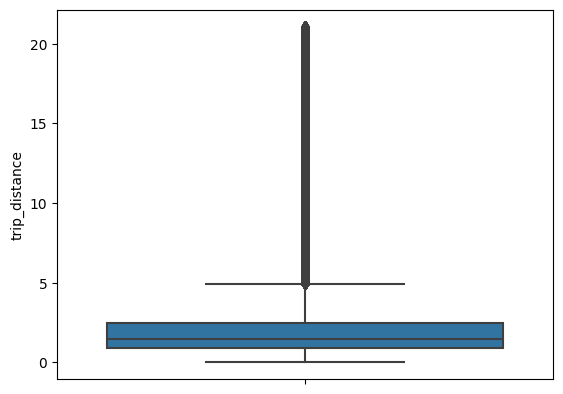

In [42]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

## 2-4. Total Fare

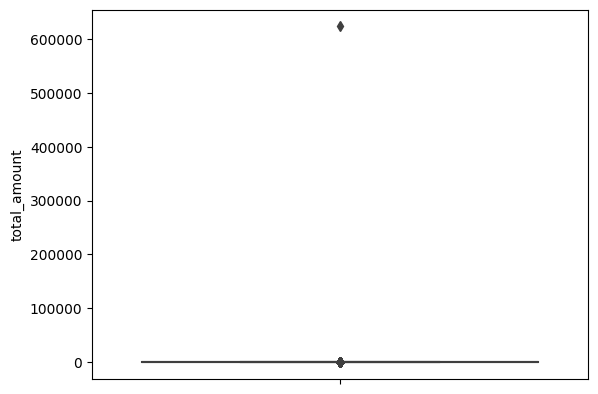

In [43]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [44]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -322.3
10 percentile value is 6.36
20 percentile value is 7.56
30 percentile value is 8.75
40 percentile value is 9.8
50 percentile value is 10.8
60 percentile value is 12.3
70 percentile value is 14.15
80 percentile value is 16.8
90 percentile value is 22.25
100 percentile value is  623261.66


In [45]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 22.25
91 percentile value is 23.16
92 percentile value is 24.3
93 percentile value is 25.55
94 percentile value is 27.0
95 percentile value is 29.12
96 percentile value is 31.8
97 percentile value is 36.3
98 percentile value is 43.26
99 percentile value is 57.06
100 percentile value is  623261.66


In [46]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 57.06
99.1 percentile value is 58.56
99.2 percentile value is 60.0
99.3 percentile value is 63.06
99.4 percentile value is 65.4
99.5 percentile value is 68.75
99.6 percentile value is 70.27
99.7 percentile value is 71.62
99.8 percentile value is 75.67
99.9 percentile value is 88.9
100 percentile value is  623261.66


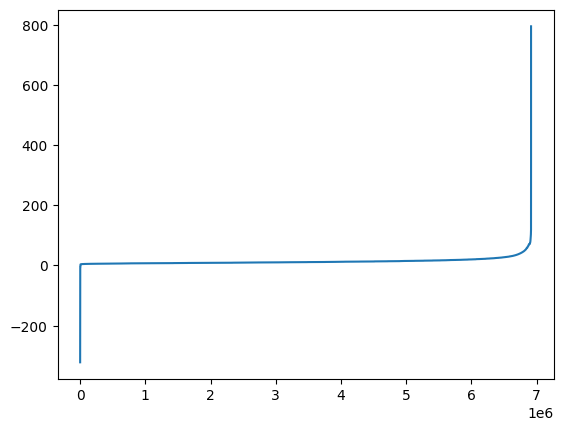

In [47]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

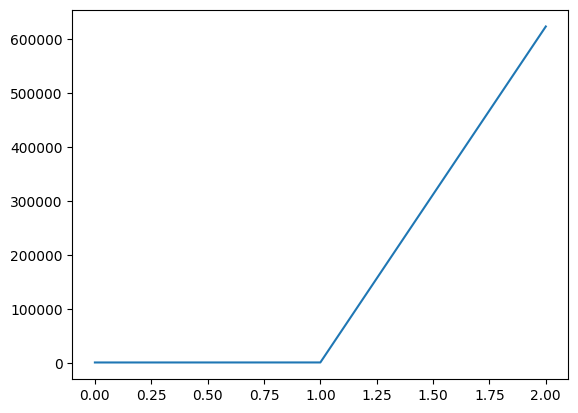

In [48]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

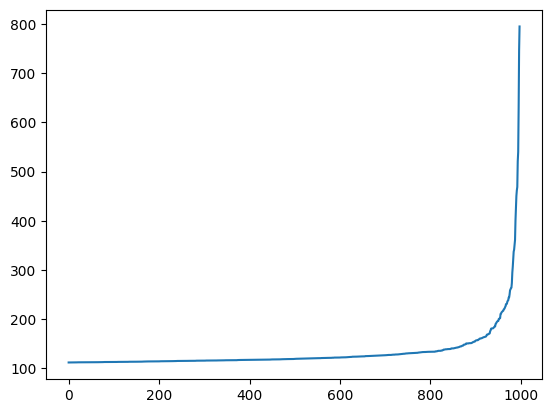

In [49]:
# we plot last 50 values excluding last two values
plt.plot(var[-1000:-2])
plt.show()

In [50]:
total_amount_diffusion = 300

300 부근에서 값이 튄다.

## Remove all outliers/erronous points

In [51]:
def map_region(dataframe, region):
    region_df = taxi_zone_df[taxi_zone_df['Borough'] == region]
    region_number = region_df['LocationID']
    
    region_arr_data = []
    for i in region_number.values:
        region_arr_data.append(dataframe[dataframe['PULocationID'] == i])
    
    region_df = pd.concat(region_arr_data, axis=0, ignore_index=True)

    return region_df
    

In [52]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    # a = new_frame.shape[0]
    # print ("Number of pickup records = ",a)
    
    # temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    # c = temp_frame.shape[0]
    # print ("Number of outliers from trip times analysis:",(a-c))
    
    
    # temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 25.52)]
    # d = temp_frame.shape[0]
    # print ("Number of outliers from trip distance analysis:",(a-d))
    
    # temp_frame = new_frame[(new_frame.Speed <= 45.28) & (new_frame.Speed >= 0)]
    # e = temp_frame.shape[0]
    # print ("Number of outliers from speed analysis:",(a-e))
    
    # temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    # f = temp_frame.shape[0]
    # print ("Number of outliers from fare analysis:",(a-f))
    
    new_frame = new_frame[(new_frame.total_amount > 0) & (new_frame.total_amount <total_amount_diffusion)]
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < trip_times_diffusion)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance <= trip_distance_99_9)]
    new_frame = new_frame[(new_frame.Speed > 0) & (new_frame.Speed <= speed_99_9)]


    
    
    # print ("Total outliers removed",a - new_frame.shape[0])
    # print ("---")
    return new_frame

In [53]:
print (f"Removing outliers in the month of Jan-{base_year}")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2019
----
fraction of data points that remain after removing outliers 0.9899749171517912


In [54]:
frame_with_durations_outliers_removed.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_times,pickup_times,Speed
0,1.0,3.8,4,246,26.30,40.583333,1.546269e+09,5.618070
1,1.0,2.7,4,87,13.30,9.583333,1.546269e+09,16.904348
2,1.0,2.3,4,233,11.75,9.066667,1.546270e+09,15.220588
3,1.0,4.7,4,263,20.15,13.900000,1.546269e+09,20.287770
4,1.0,3.9,4,261,17.15,9.350000,1.546271e+09,25.026738


In [55]:
frame_with_durations_outliers_removed['PULocationID'].value_counts()

237    330660
236    321133
161    310065
162    274968
230    261021
        ...  
153       268
128        66
120        38
105        13
104         1
Name: PULocationID, Length: 68, dtype: int64

## Data-preperation

## Time-binning

In [56]:
def set_unixtimestamp():
    unix_times = []
    for year in range(2):
        tmp = []
        for i in range(1,base_month_count+1):
            date_time = datetime.datetime(base_year+year, i, 1, 0, 0)
            tmp.append(int(time.mktime(date_time.timetuple())))
        unix_times.append(tmp)
    return unix_times

In [57]:
print(set_unixtimestamp())

[[1546268400], [1577804400]]


In [58]:
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]

    unix_times = set_unixtimestamp()
    
    start_pickup_unix=unix_times[year-base_year][month-1]

    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [59]:
jan_base_year_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,base_year)

jan_base_year_groupby = jan_base_year_frame[['PULocationID','pickup_bins','trip_distance']].groupby(['PULocationID','pickup_bins']).count()

In [60]:
jan_base_year_frame.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_times,pickup_times,Speed,pickup_bins
0,1.0,3.8,4,246,26.30,40.583333,1.546269e+09,5.618070,34
1,1.0,2.7,4,87,13.30,9.583333,1.546269e+09,16.904348,34
2,1.0,2.3,4,233,11.75,9.066667,1.546270e+09,15.220588,35
3,1.0,4.7,4,263,20.15,13.900000,1.546269e+09,20.287770,34
4,1.0,3.9,4,261,17.15,9.350000,1.546271e+09,25.026738,37


In [61]:
jan_base_year_groupby.head(10)

trip_distance
PULocationID pickup_bins               
4            -19                      1
              33                      1
              34                      4
              35                     11
              36                      9
              37                     11
              38                     13
              39                     10
              40                     19
              41                     11

In [62]:
def datapreparation(month,month_no,year_no):
    
    print(f"start {month_no} month ..")

    print ("Return with trip times..")
    new_frame = map_region(month, region)

    frame_with_durations = return_with_trip_times(new_frame)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['PULocationID','pickup_bins','trip_distance']].groupby(['PULocationID','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame

read_months = []
for i in range(1,base_month_count+1):
    if i < 10:
        read_months.append(pd.read_parquet(f'yellow_tripdata_{base_year+1}-0{i}.parquet',engine='pyarrow'))
    else:
        read_months.append(pd.read_parquet(f'yellow_tripdata_{base_year+1}-{i}.parquet',engine='pyarrow'))


months_frame = []
months_groupby = []
for index, month in enumerate(read_months):
    tmp_frame, tmp_groupby = datapreparation(month, index+1,base_year+1)
    months_frame.append(tmp_frame)
    months_groupby.append(tmp_groupby)

start 1 month ..
Return with trip times..
Remove outliers..
Final groupbying..


## Smoothing

In [63]:
# number of 10min indices for jan 2019= 24*31*60/10 = max_pickup_bins_len
interval = 10
days = [31,29,31,30,31,30,31,31,30,31,30,31]
pickup_bins_len = []

for day in days:
    pickup_bins_len.append(int(24*60*day/interval))
max_pickup_bins_len = max(pickup_bins_len)
print(max_pickup_bins_len)

4464


In [64]:
def return_unq_pickup_bins(frame):
    values = []
    for i in nyc_region_number.values:
    # for i in range(1,266):
        new = frame[frame['PULocationID'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [65]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

jan_base_year_unique = return_unq_pickup_bins(jan_base_year_frame)
months_unique = []
for frame in months_frame:
    months_unique.append(return_unq_pickup_bins(frame))

In [66]:
for i in range(1,len(jan_base_year_unique)):

    print("for the ",i,f"th cluster number of {interval} min intavels with zero pickups: ",max_pickup_bins_len - len(set(jan_base_year_unique[i-1])))
    print('-'*60)

for the  1 th cluster number of 10 min intavels with zero pickups:  667
------------------------------------------------------------
for the  2 th cluster number of 10 min intavels with zero pickups:  3158
------------------------------------------------------------
for the  3 th cluster number of 10 min intavels with zero pickups:  448
------------------------------------------------------------
for the  4 th cluster number of 10 min intavels with zero pickups:  447
------------------------------------------------------------
for the  5 th cluster number of 10 min intavels with zero pickups:  206
------------------------------------------------------------
for the  6 th cluster number of 10 min intavels with zero pickups:  617
------------------------------------------------------------
for the  7 th cluster number of 10 min intavels with zero pickups:  338
------------------------------------------------------------
for the  8 th cluster number of 10 min intavels with zero pickups:  

In [67]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(1,nyc_regions_cnt+1):
        smoothed_bins=[]
        for i in range(max_pickup_bins_len):
            if i in values[r-1]:
                smoothed_bins.append(count_values[ind-1])
                ind+=1
            else:
                # TODO
                # smoothed_bins.append(1)
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [68]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(1,nyc_regions_cnt+1):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(max_pickup_bins_len):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r-1]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind-1]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,max_pickup_bins_len):
                        if  j not in values[r-1]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((max_pickup_bins_len-1-i)+2)*1.0                               
                        for j in range(i,max_pickup_bins_len):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(max_pickup_bins_len-1-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,max_pickup_bins_len):
                        if  j not in values[r-1]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [69]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_base_year_fill = fill_missing(jan_base_year_groupby['trip_distance'].values,jan_base_year_unique)


#Smoothing Missing values of Jan-2015
jan_base_year_smooth = smoothing(jan_base_year_groupby['trip_distance'].values,jan_base_year_unique)


In [70]:
# number of 10min indices for jan 2015= 24*31*60/10 = max_pickup_bins_len
# number of 10min indices for jan 2016 = 24*31*60/10 = max_pickup_bins_len
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have max_pickup_bins_len values, therefore 40*max_pickup_bins_len = 178560 (length of the jan_base_year_fill)
print("number of 10min intravels among all the clusters ",len(jan_base_year_fill))

number of 10min intravels among all the clusters  308016


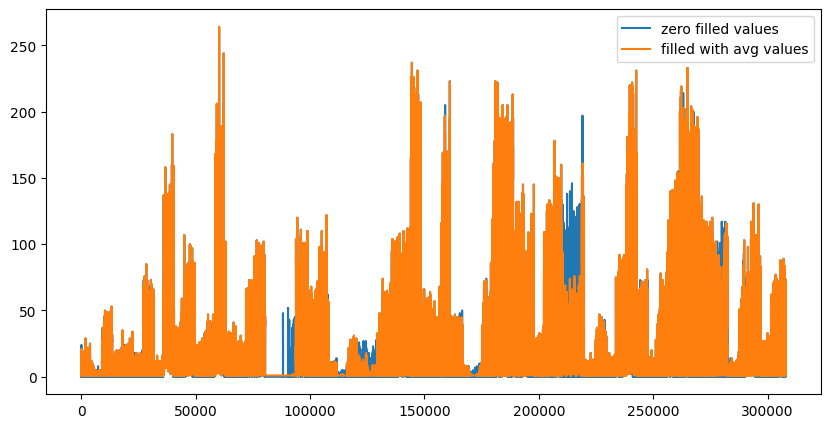

In [71]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_base_year_fill[:len(jan_base_year_fill)], label="zero filled values")
plt.plot(jan_base_year_smooth[:len(jan_base_year_fill)], label="filled with avg values")
plt.legend()
plt.show()


In [72]:
jan_base_year_smooth = smoothing(jan_base_year_groupby['trip_distance'].values,jan_base_year_unique)

months_smooth = []
for groupby, unique in zip(months_groupby, months_unique):
    # smoothing을 할 것인가 filling을 할것인가
    months_smooth.append(smoothing(groupby['trip_distance'].values,unique))

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []


# number of 10min indices for jan 2019= 24*31*60/10 = 4464      # pickup_bins_len[0]
# number of 10min indices for jan 2020 = 24*31*60/10 = 4464     # pickup_bins_len[0]
# number of 10min indices for feb 2020 = 24*29*60/10 = 4176     # pickup_bins_len[1]
# number of 10min indices for march 2020 = 24*31*60/10 = 4464   # pickup_bins_len[2]
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# nyc_regions_cnt개의 맨허튼 지역
for i in range(1,nyc_regions_cnt+1):
    cum = []
    for index, smooth in enumerate(months_smooth):
        cum += smooth[pickup_bins_len[index]*(i-1):pickup_bins_len[index]*i]
    regions_cum.append(cum)

print(len(regions_cum))
print(len(regions_cum[0]))


69
4464


## Time series and Fourier Transforms

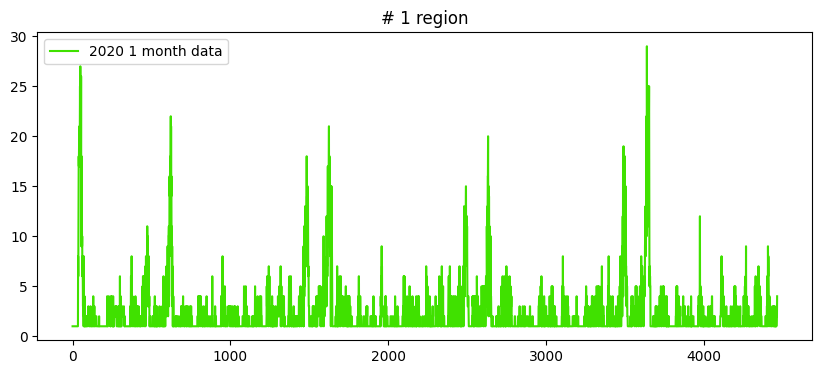

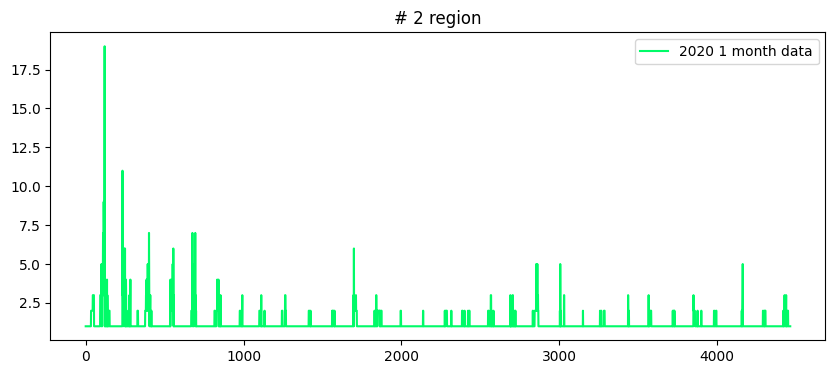

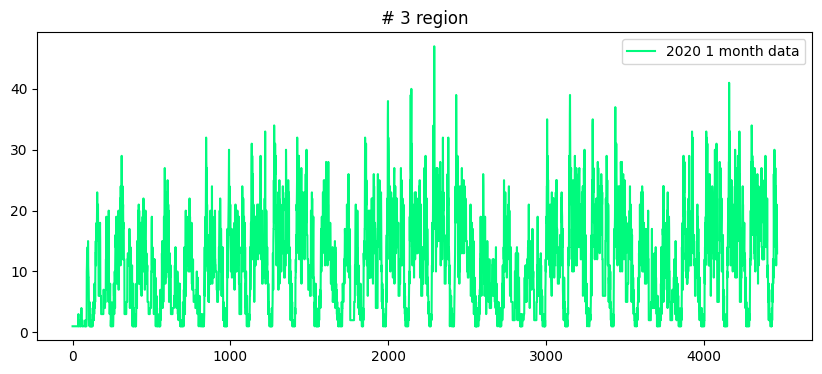

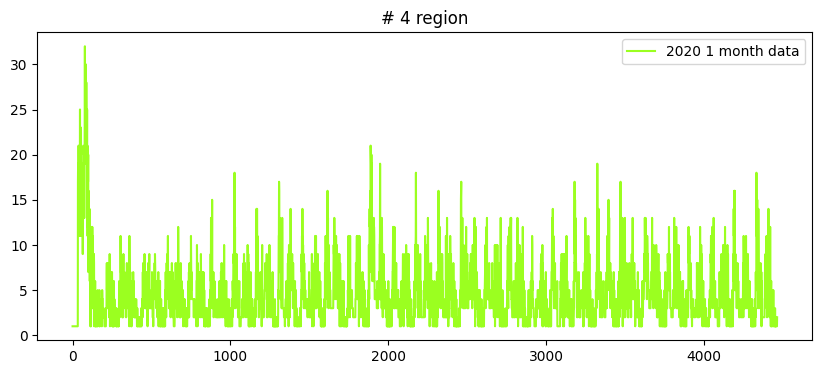

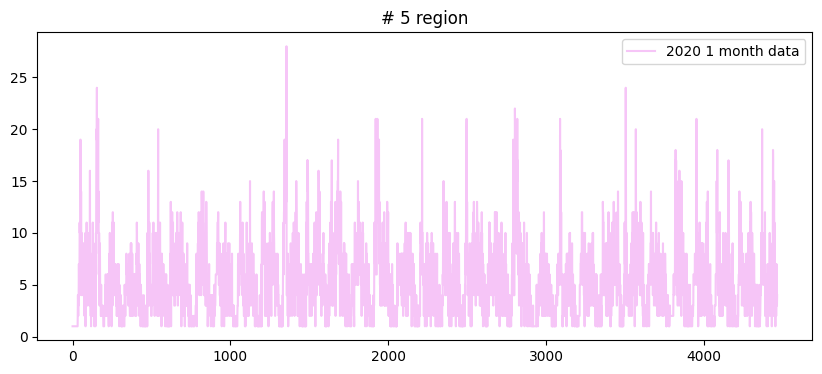

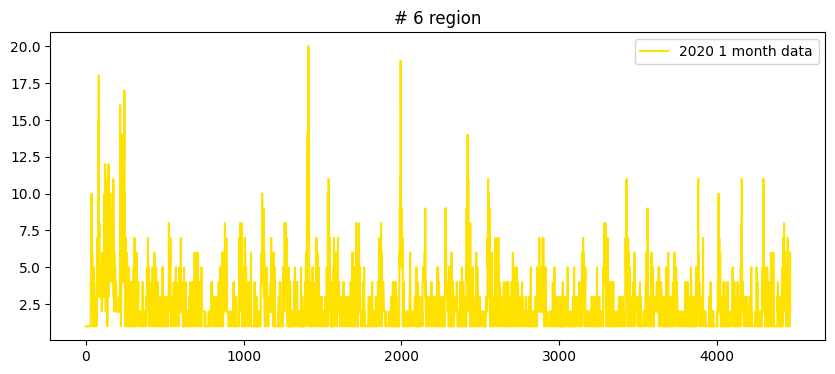

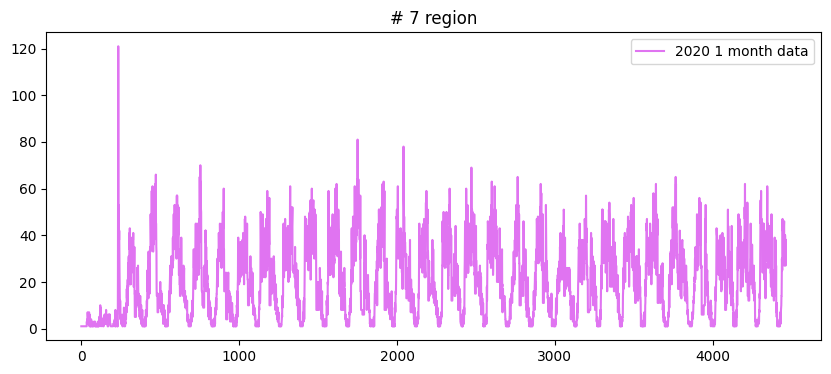

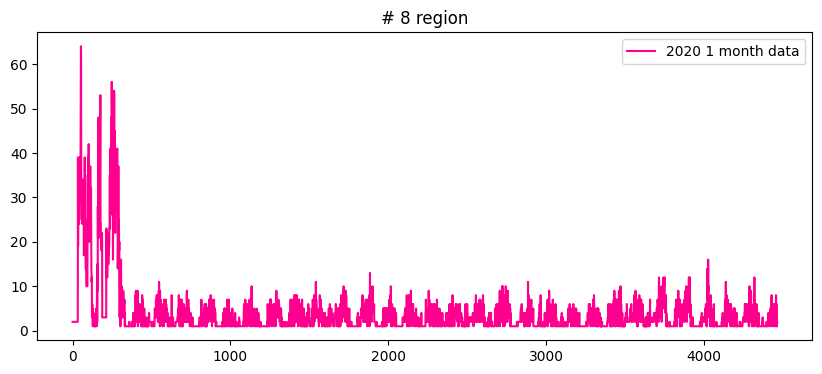

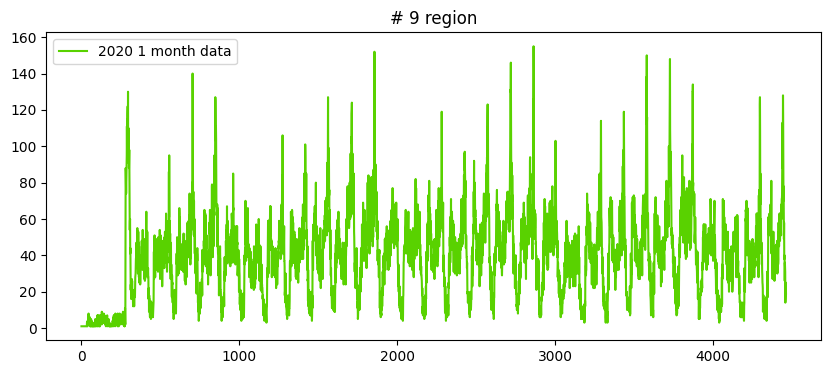

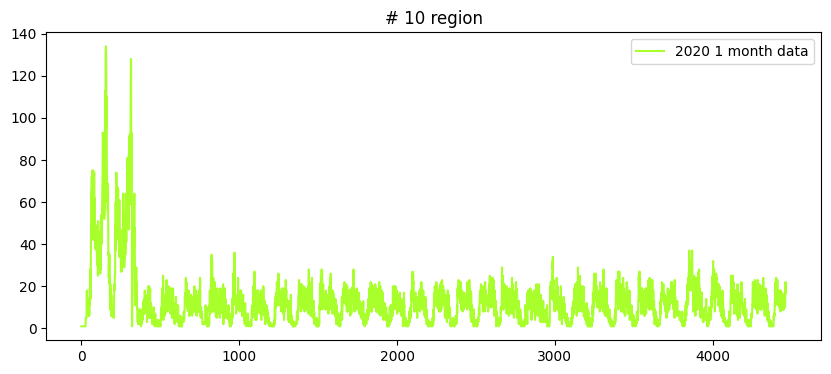

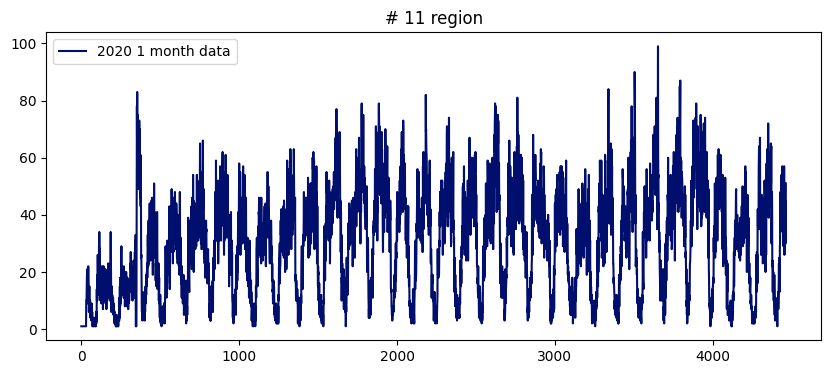

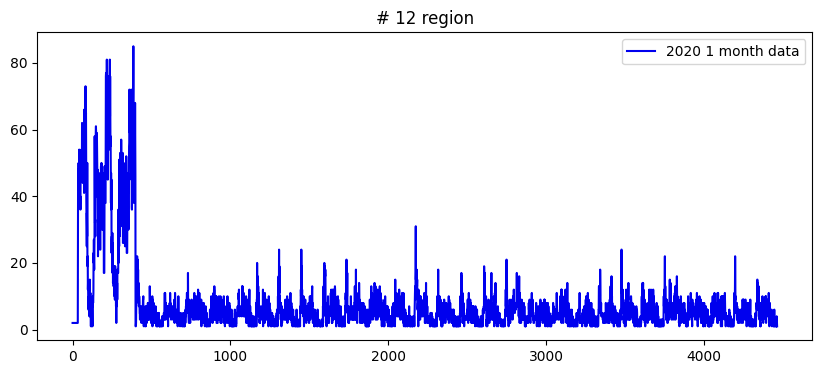

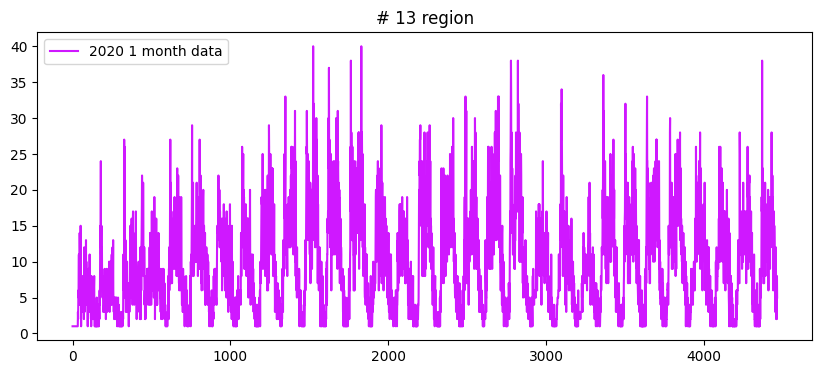

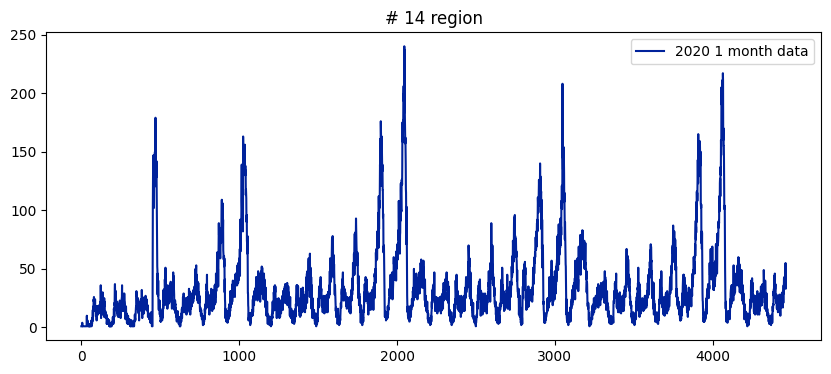

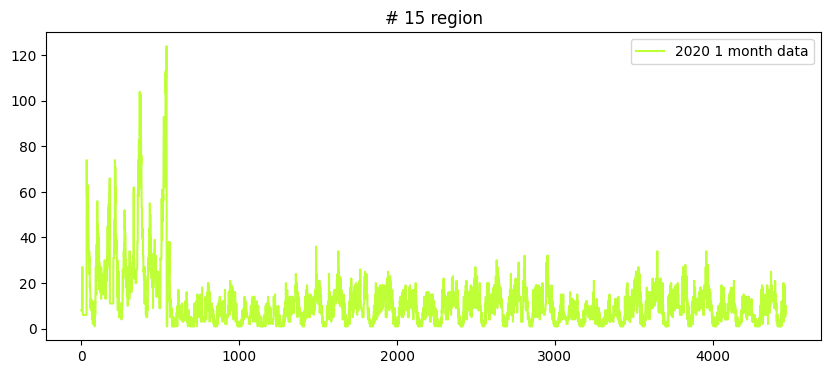

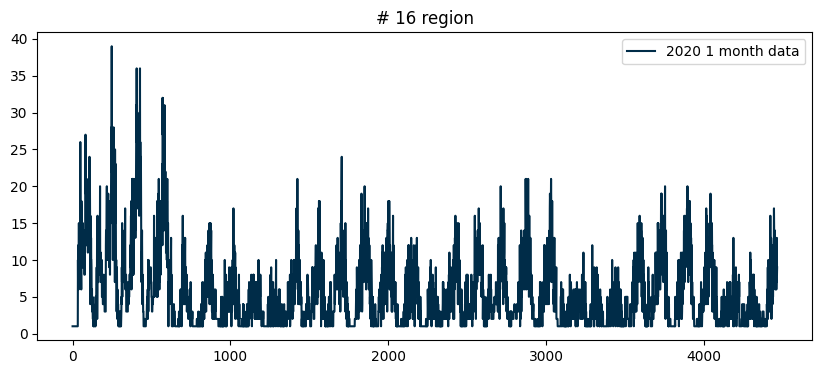

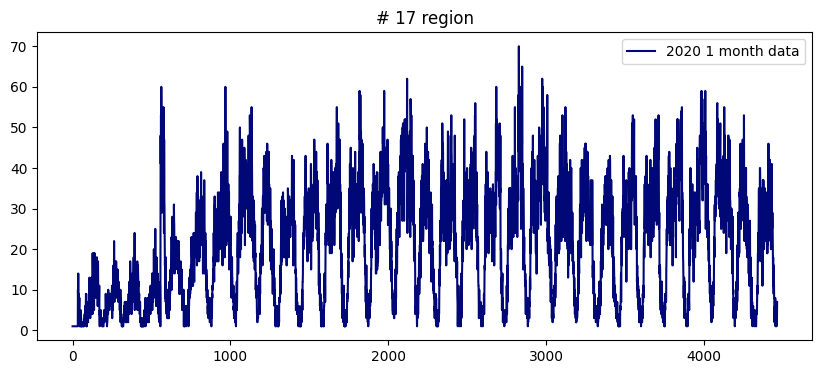

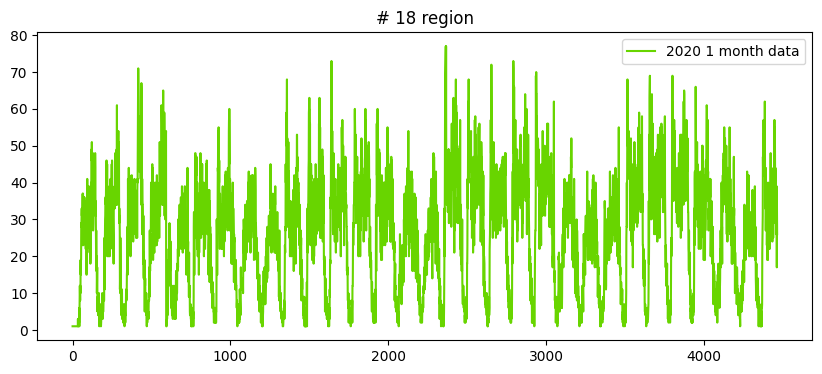

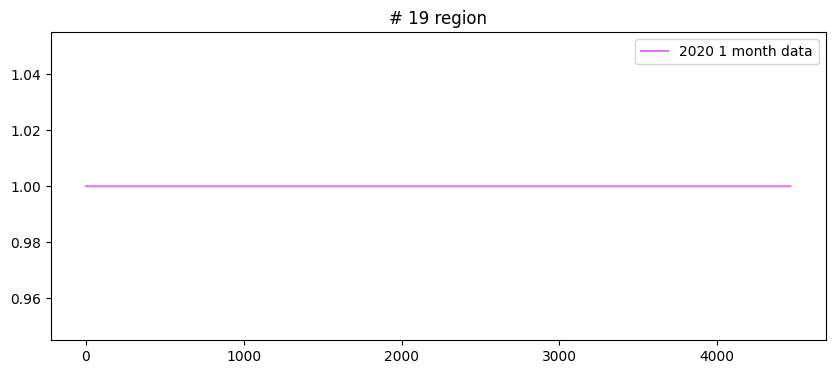

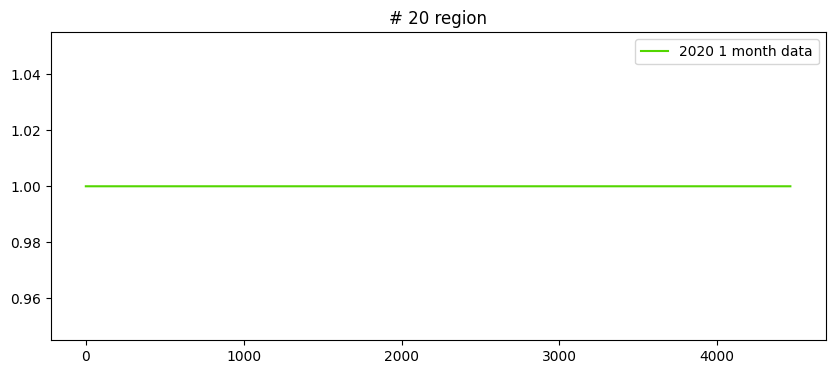

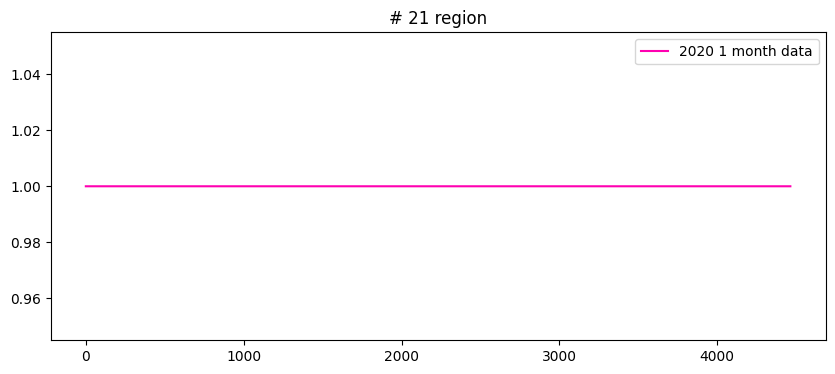

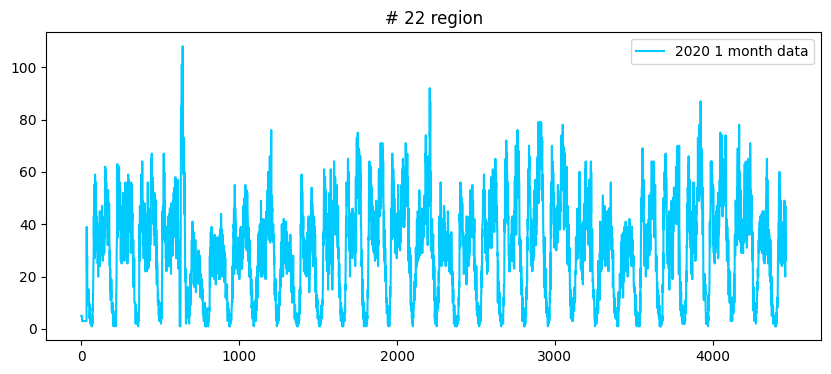

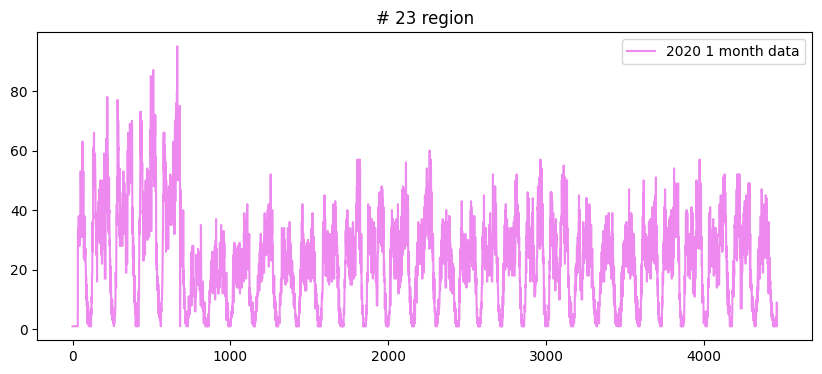

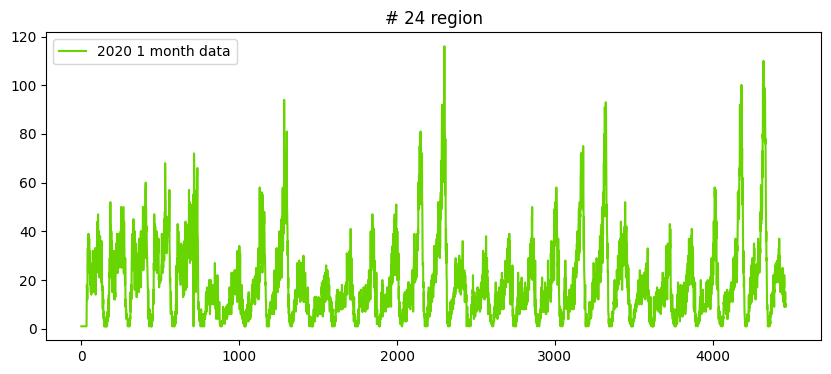

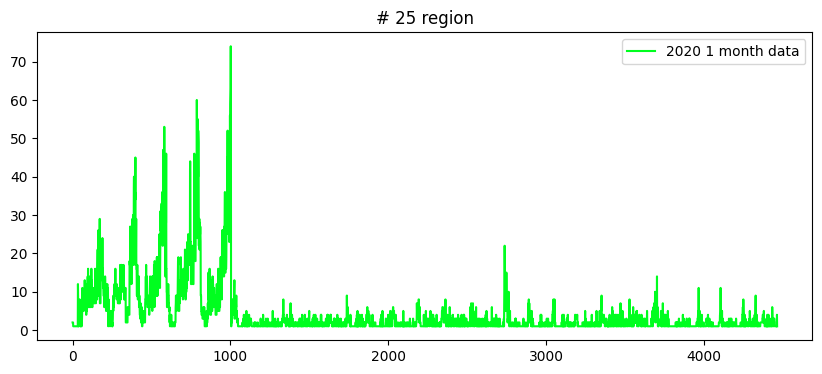

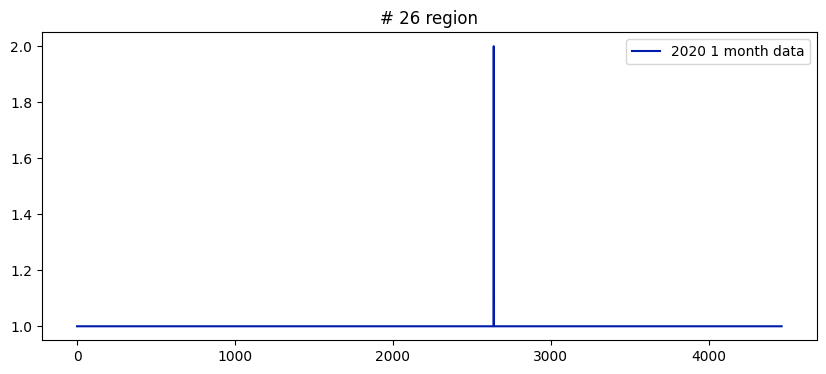

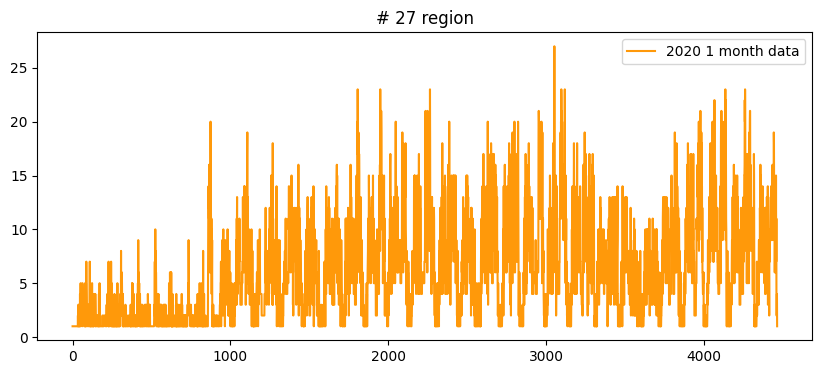

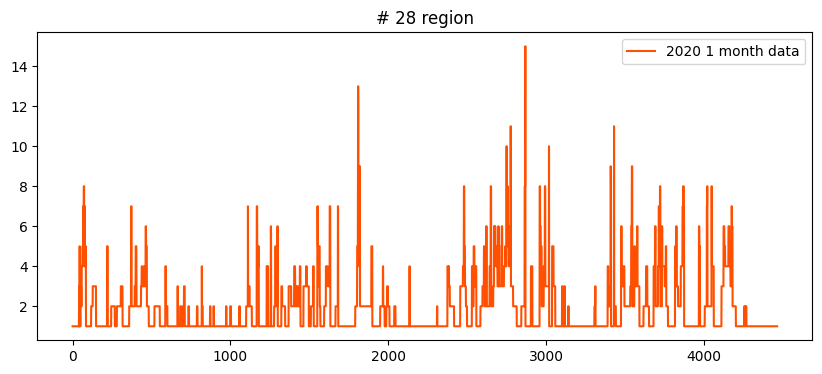

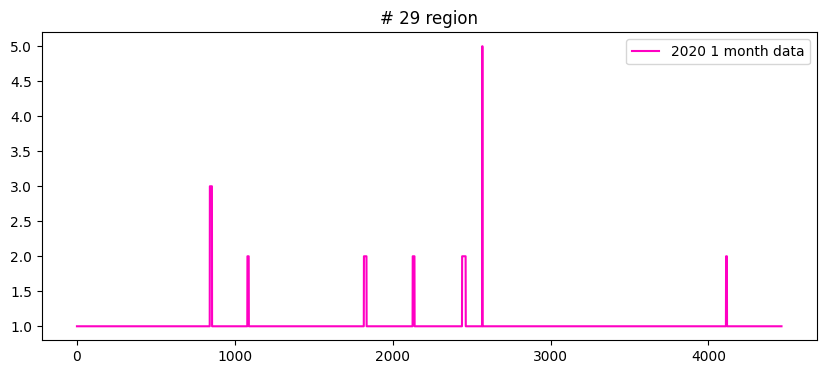

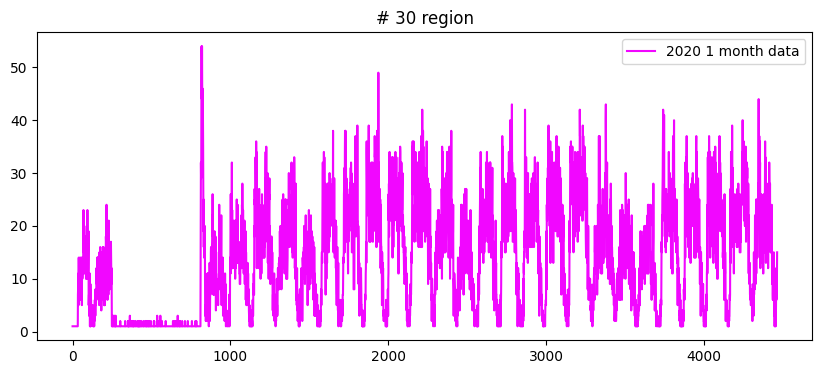

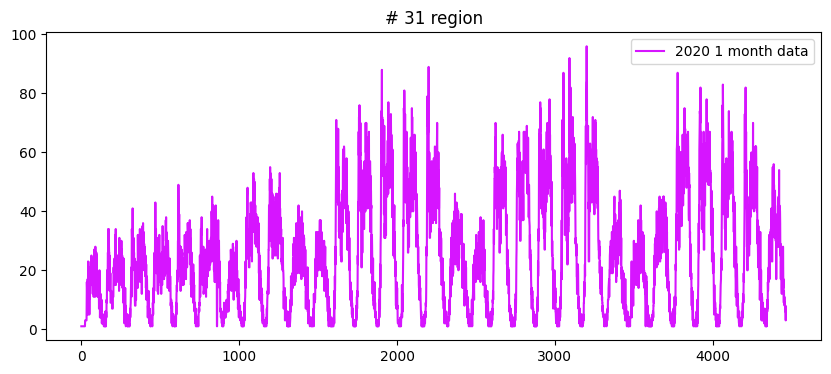

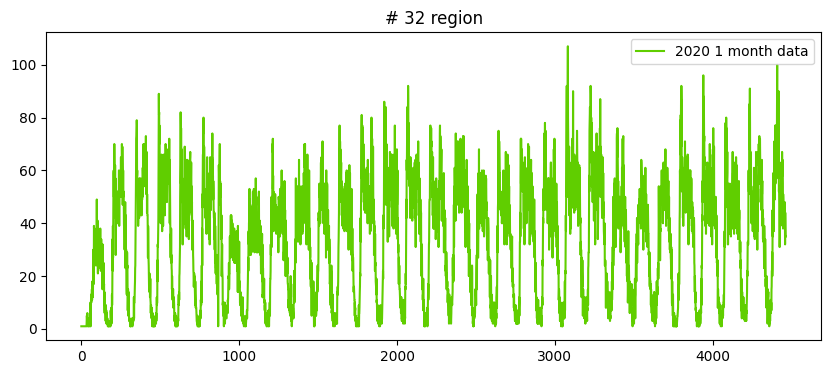

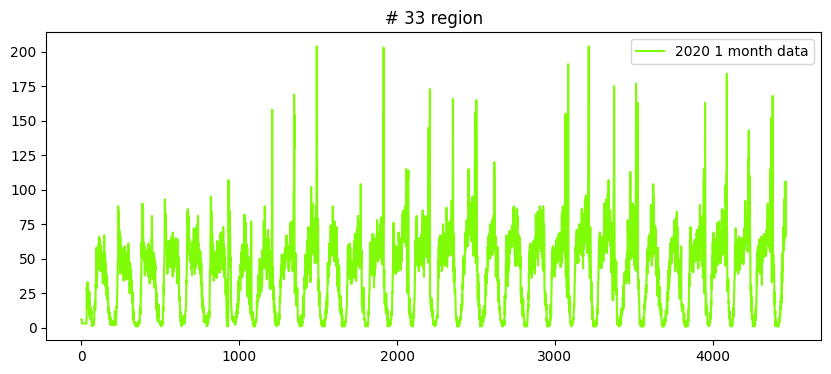

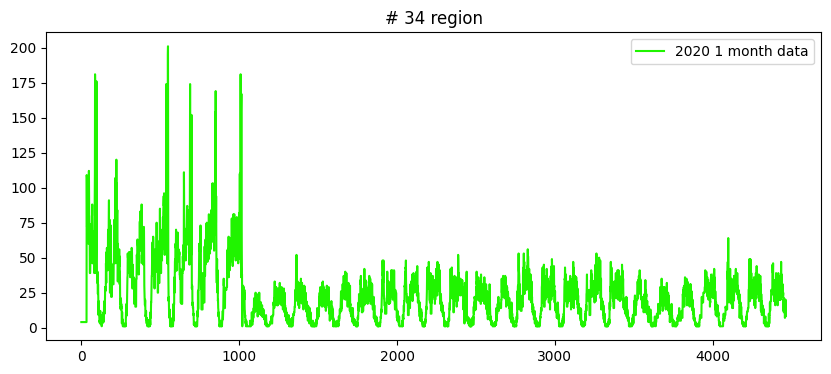

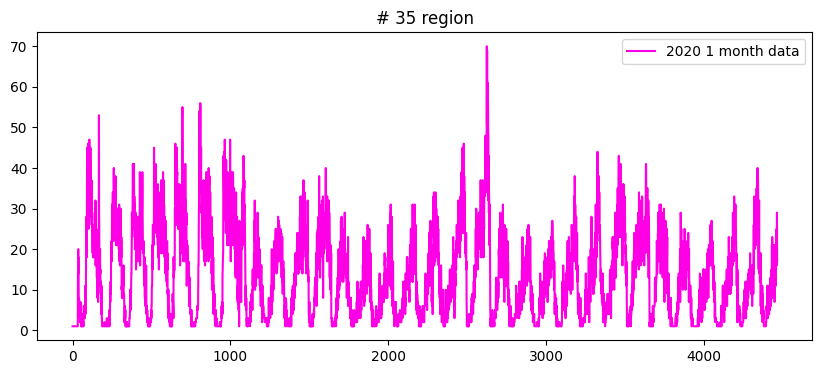

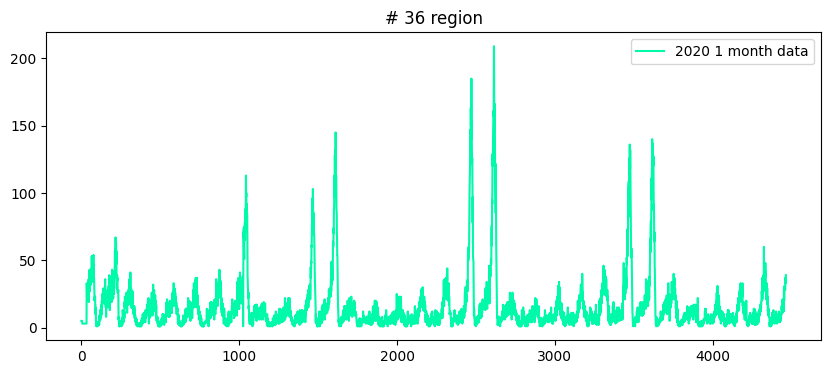

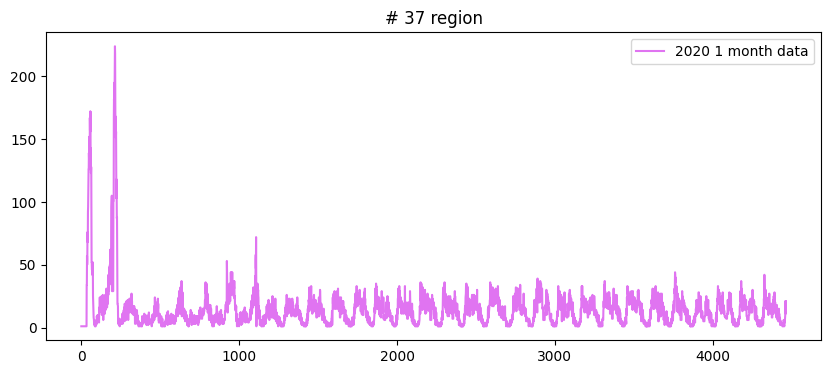

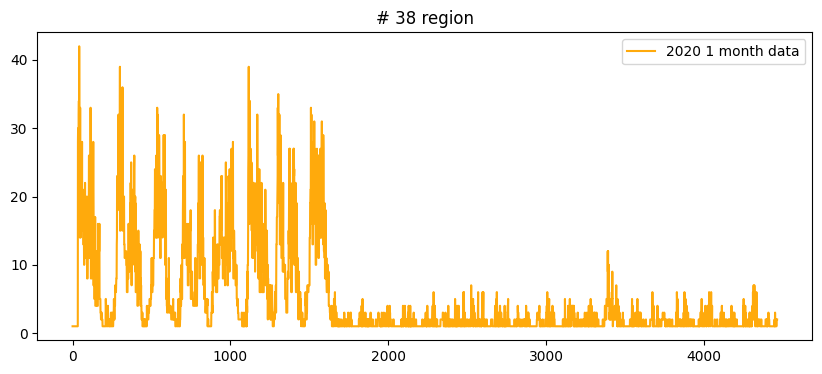

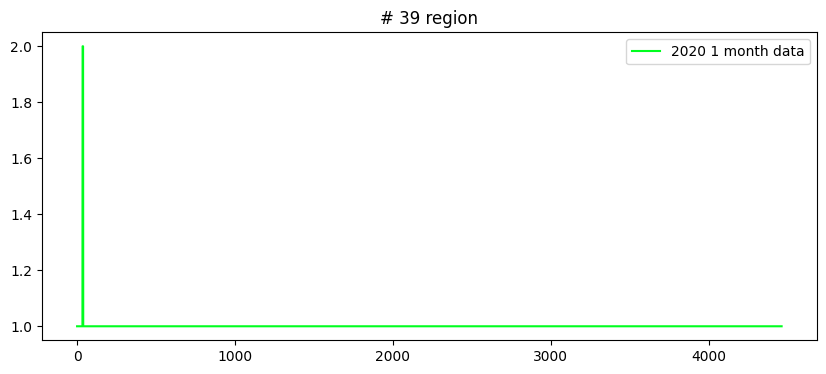

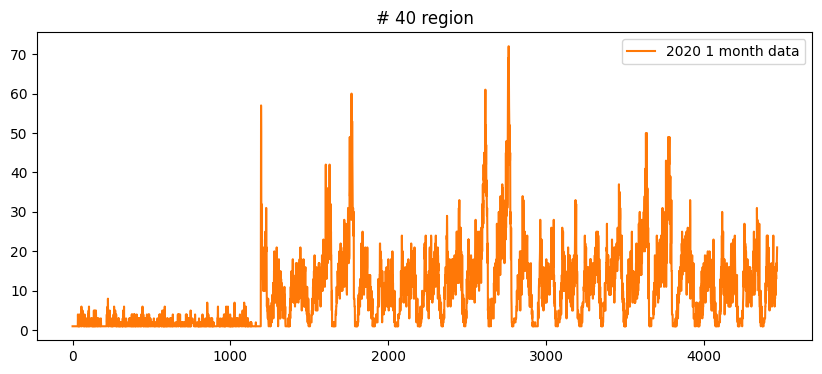

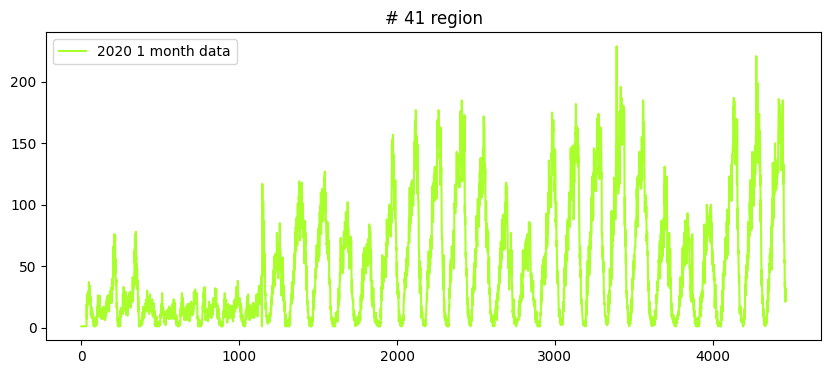

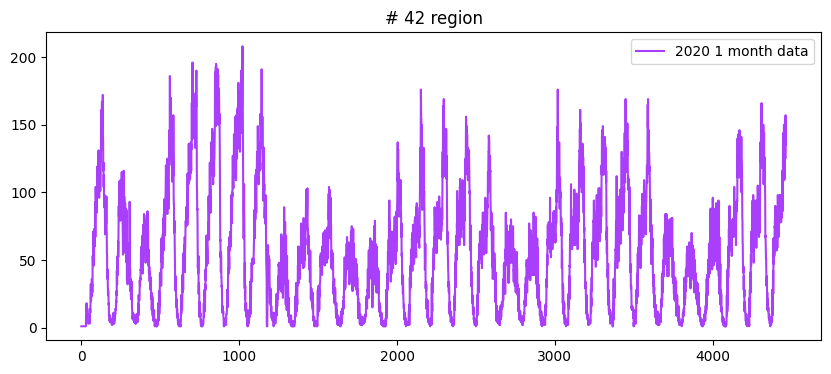

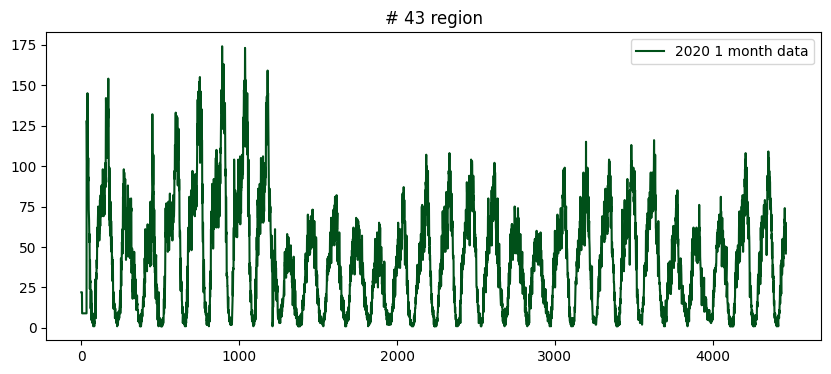

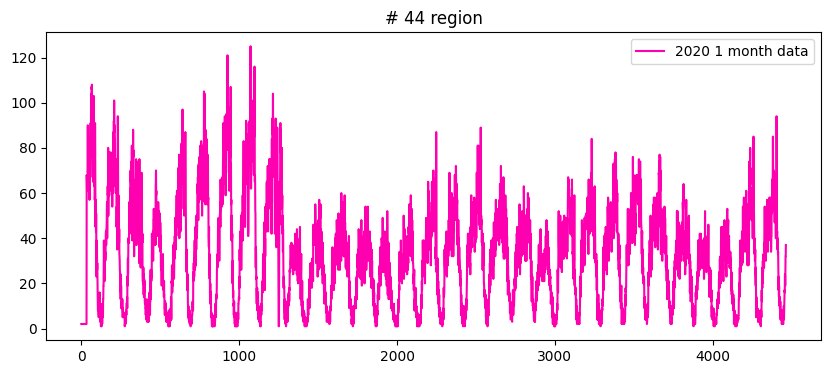

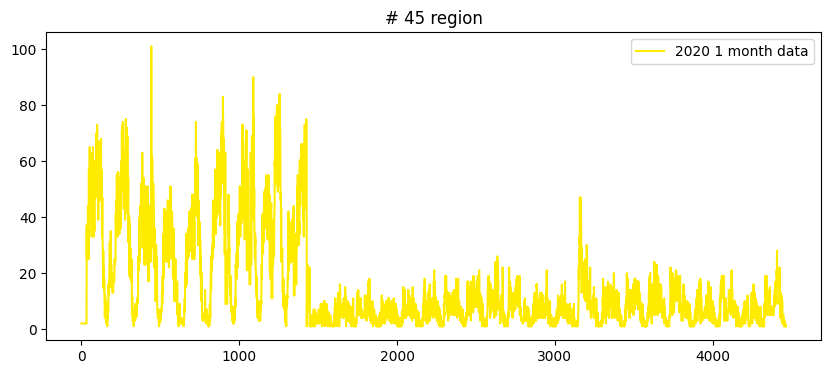

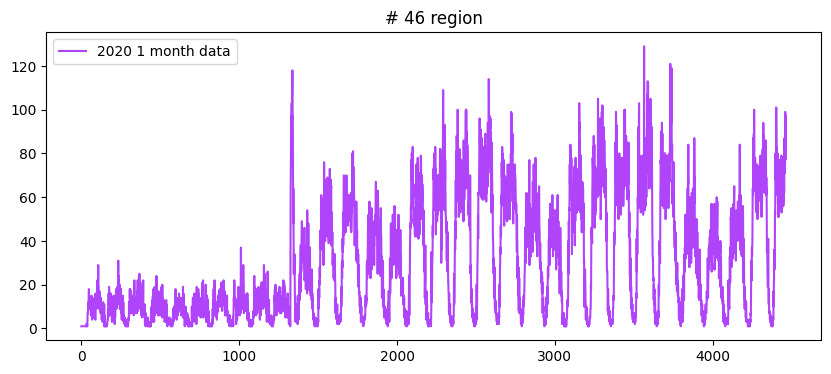

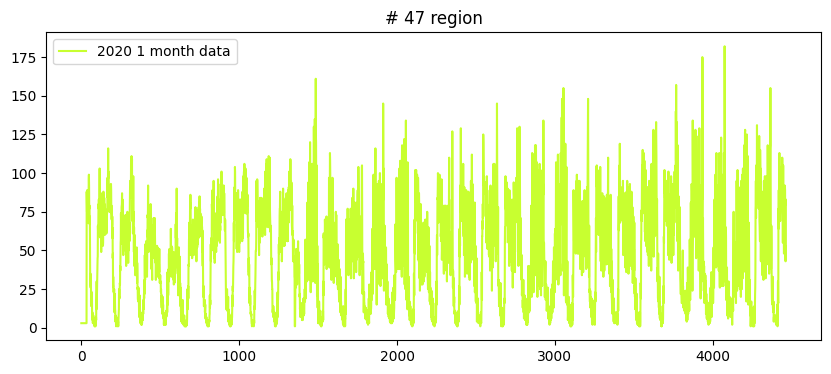

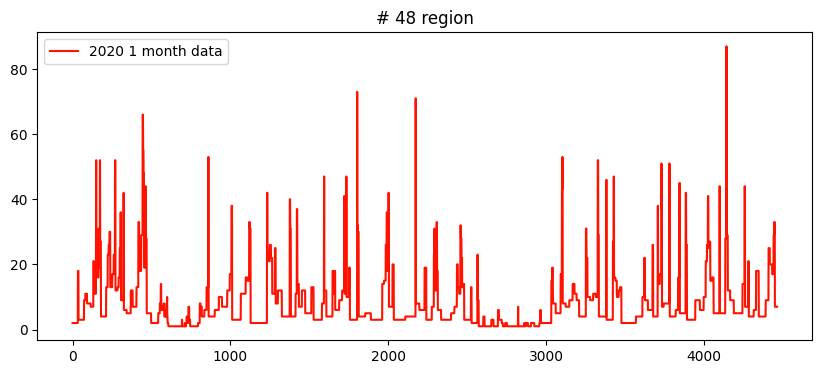

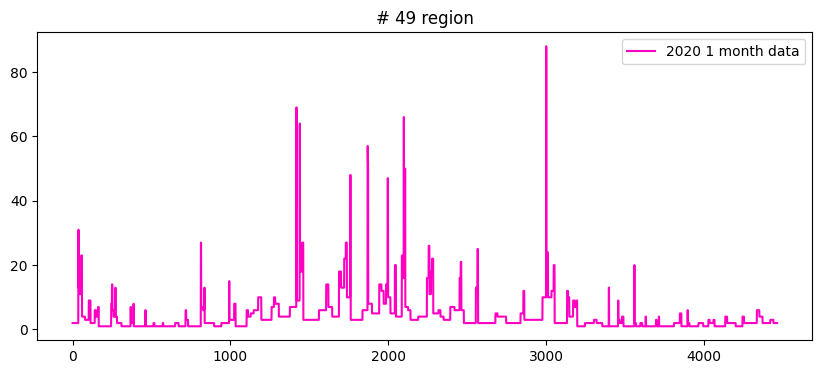

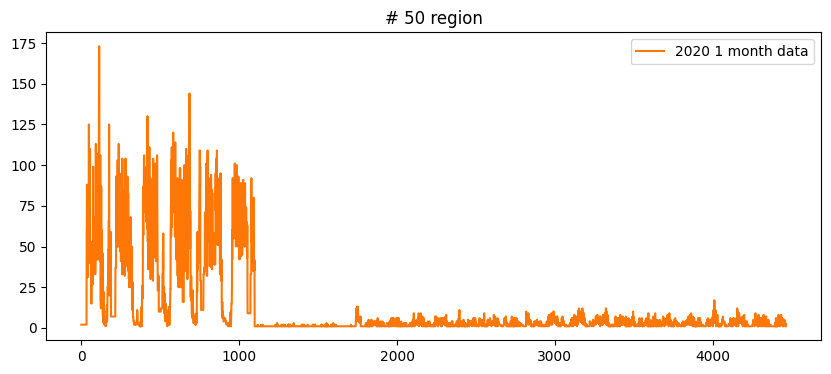

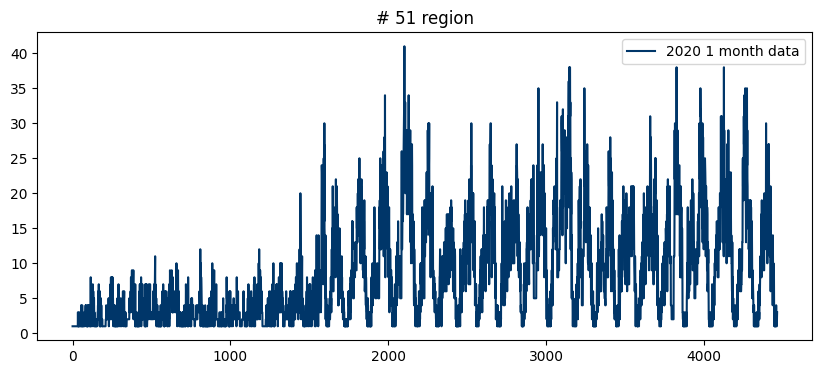

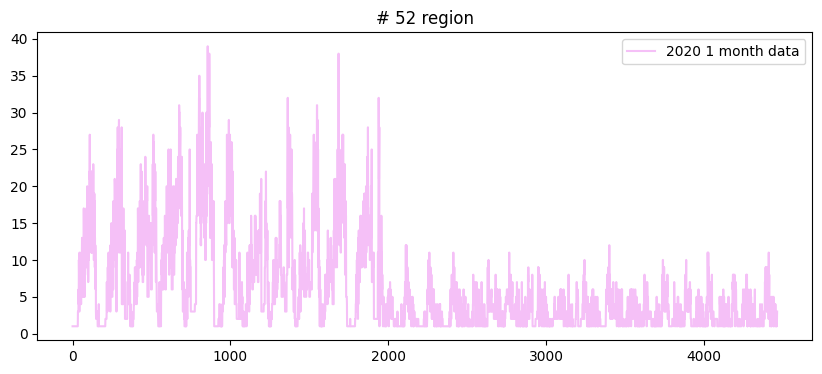

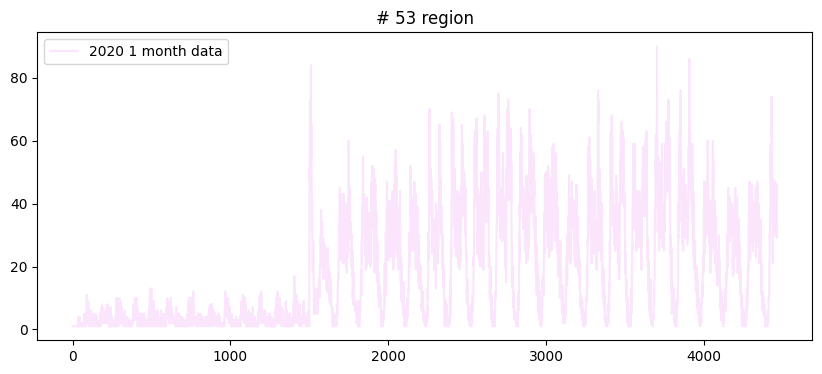

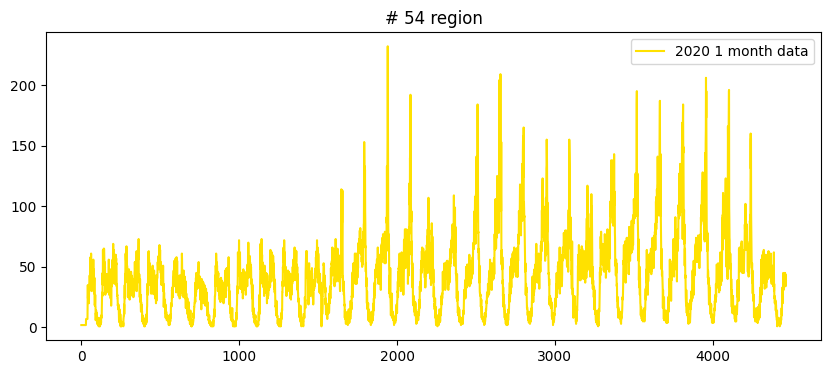

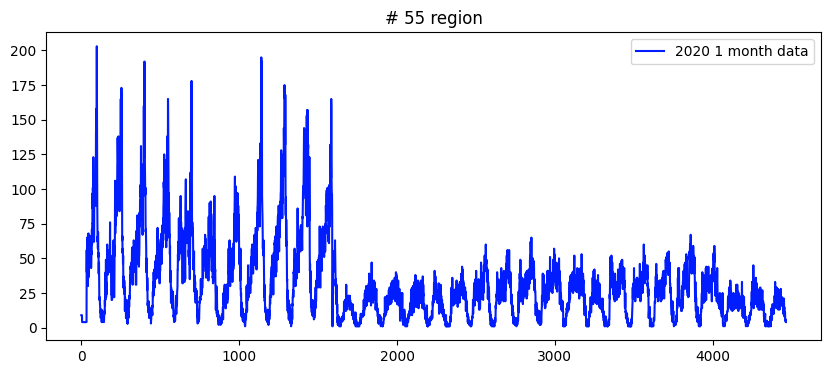

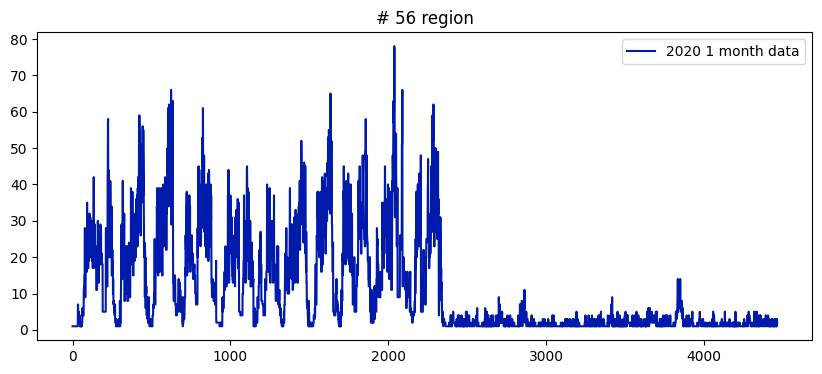

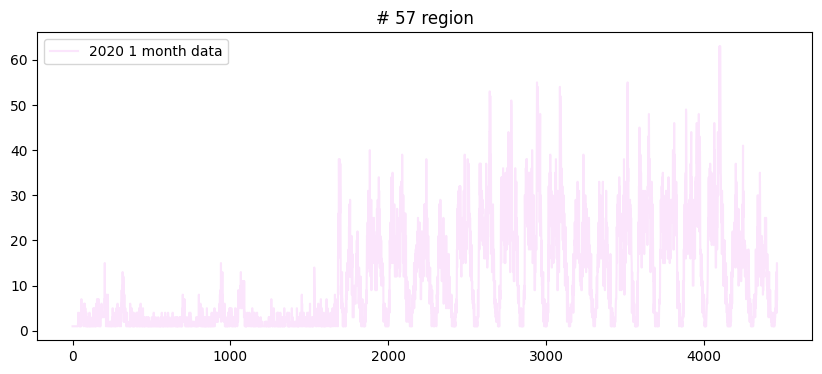

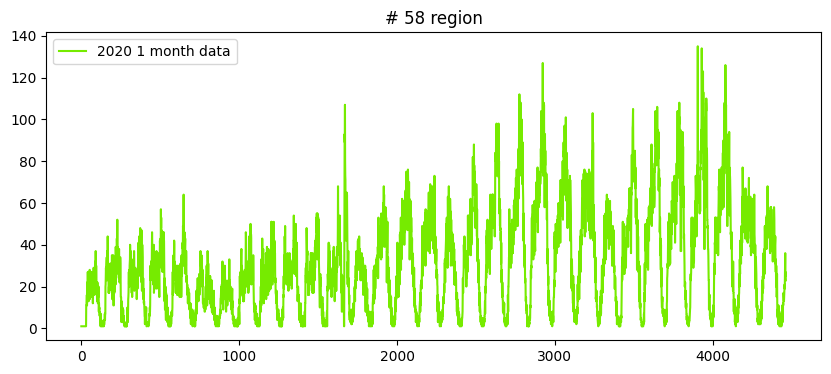

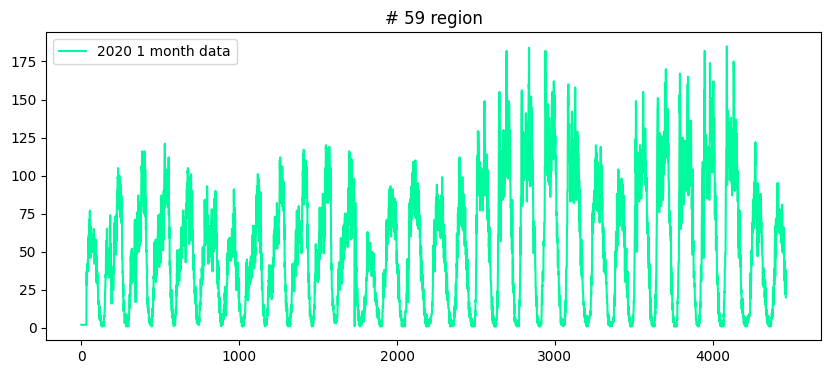

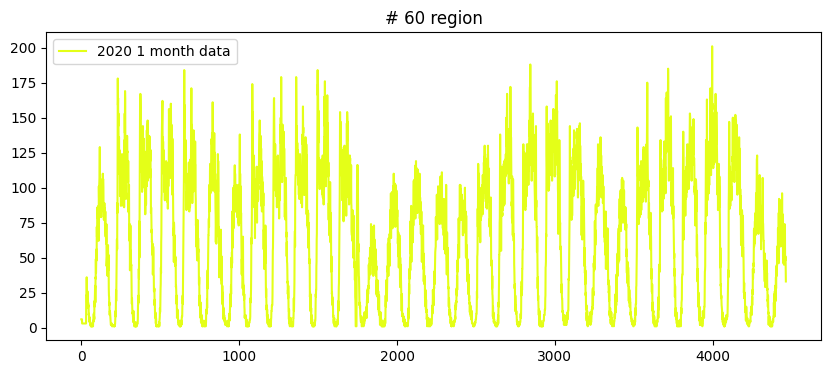

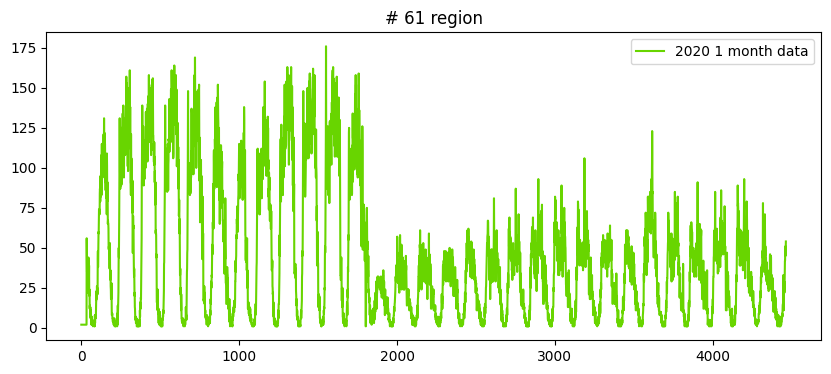

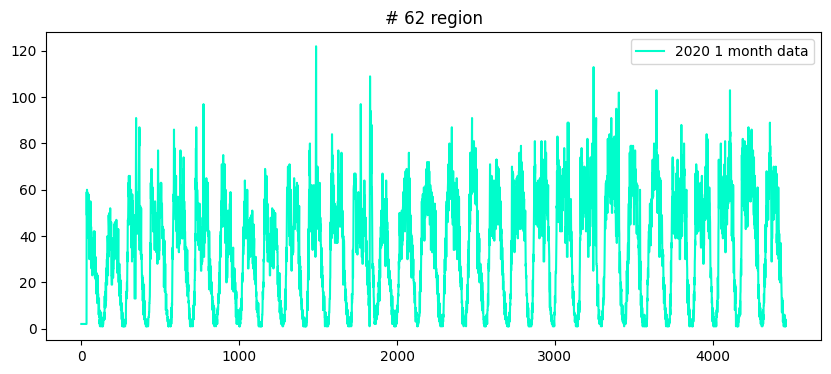

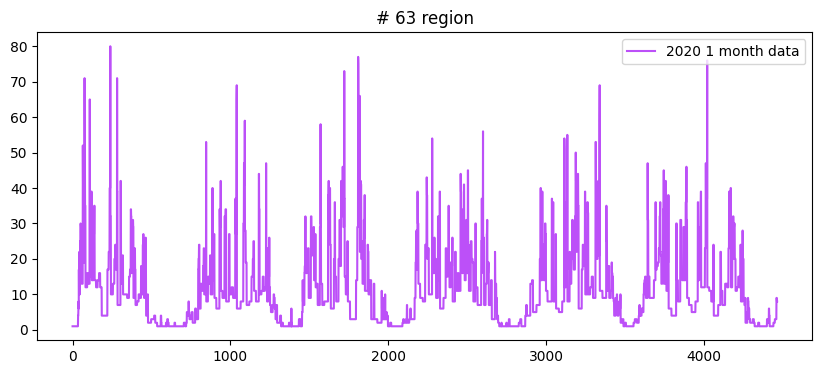

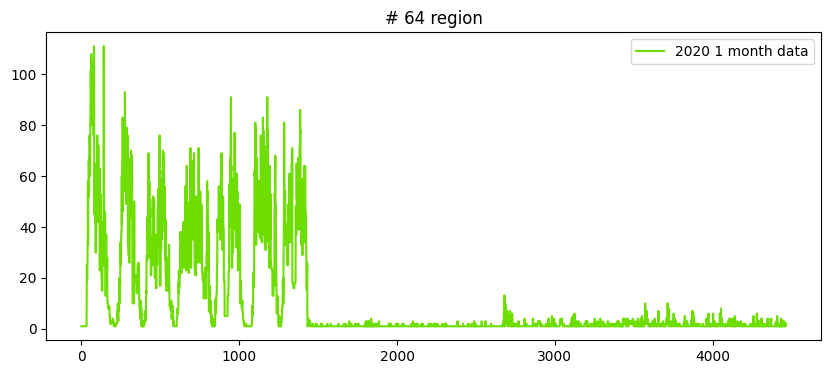

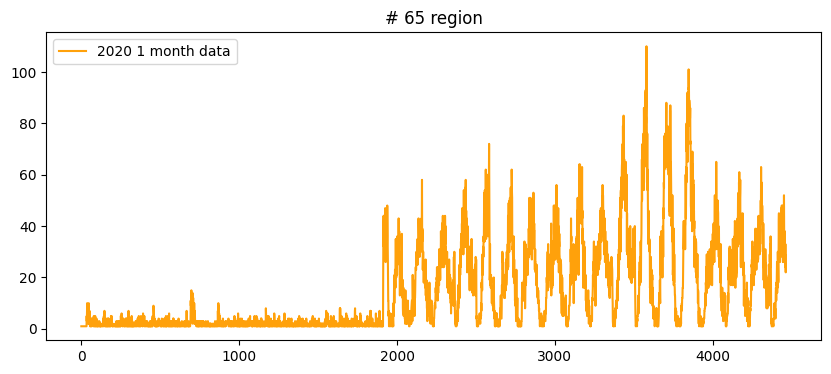

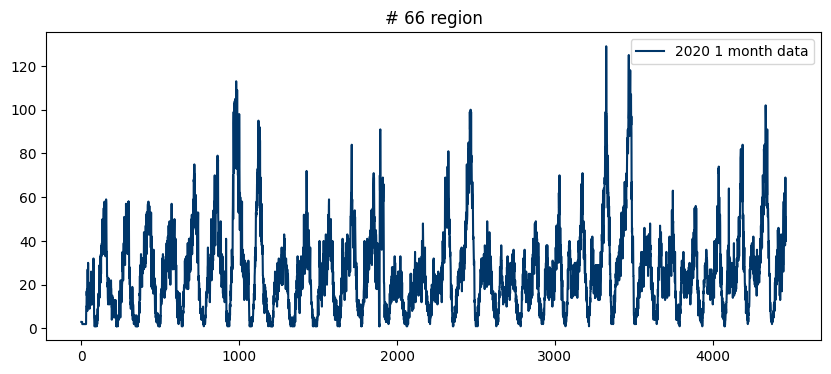

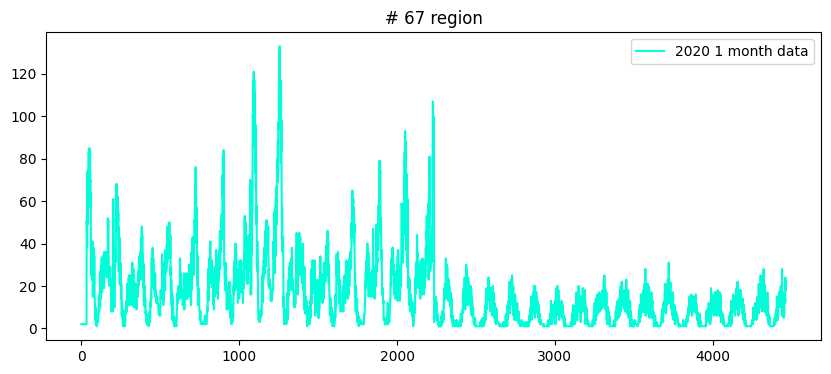

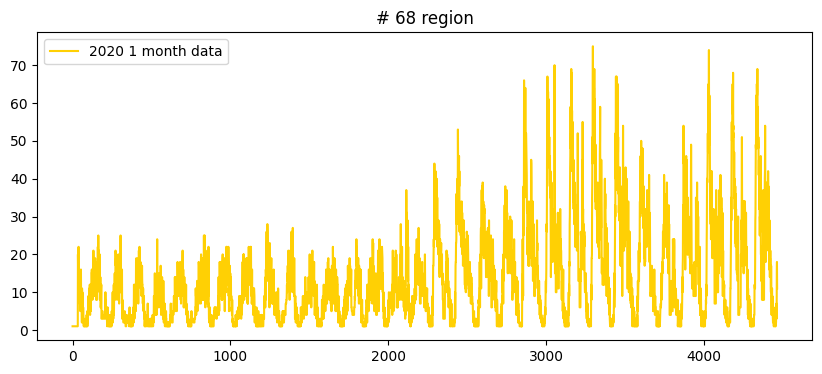

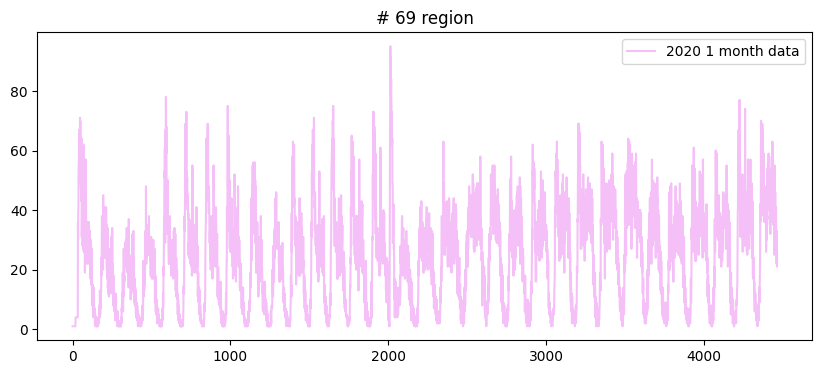

In [73]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
x_list = []
x_list.append(list(range(0,pickup_bins_len[0])))
for i in range(1,base_month_count):
    x_list.append(list(range(sum(pickup_bins_len[:i]),sum(pickup_bins_len[:i+1]))))

# first_x = list(range(0,pickup_bins_len[0])) # 0, interval_1
# second_x = list(range(pickup_bins_len[0],sum(pickup_bins_len[0:2]))) # interval_1, inerval_1 + interval_2
# third_x = list(range(sum(pickup_bins_len[0:2]),sum(pickup_bins_len[0:3]))) # inerval_1 + interval_2, interval_1 + interval_2 + interval_3
for i in range(nyc_regions_cnt):
    plt.figure(figsize=(10,4))
    for idx, x in enumerate(x_list):
        if idx == 0:
            plt.plot(x,regions_cum[i][:pickup_bins_len[0]], color=uniqueish_color(), label=f"{base_year+1} {idx+1} month data")
        elif idx == nyc_regions_cnt-1:
            plt.plot(x,regions_cum[i][sum(pickup_bins_len[:idx]):], color=uniqueish_color(), label=f"{base_year+1} {idx+1} month data")
        else:
            plt.plot(x,regions_cum[i][sum(pickup_bins_len[:idx]):sum(pickup_bins_len[:idx+1])], color=uniqueish_color(), label=f"{base_year+1} {idx+1} month data")


    # plt.plot(first_x,regions_cum[i][:pickup_bins_len[0]], color=uniqueish_color(), label='2020 Jan month data')
    # plt.plot(second_x,regions_cum[i][pickup_bins_len[0]:sum(pickup_bins_len[0:2])], color=uniqueish_color(), label='2020 feb month data')
    # plt.plot(third_x,regions_cum[i][sum(pickup_bins_len[0:2]):], color=uniqueish_color(), label='2020 march month data')
    plt.title(f'# {i+1} region')
    plt.legend()
    plt.show()
# 그래프 해석
# title: i 번째 지역
# x축: 픽업 구간 예] 0 ~ 10 = 2020년 1월 1일 00시 00분 ~ 10분
# y축: i 번째 지역의 interval 간 픽업 발생 횟수

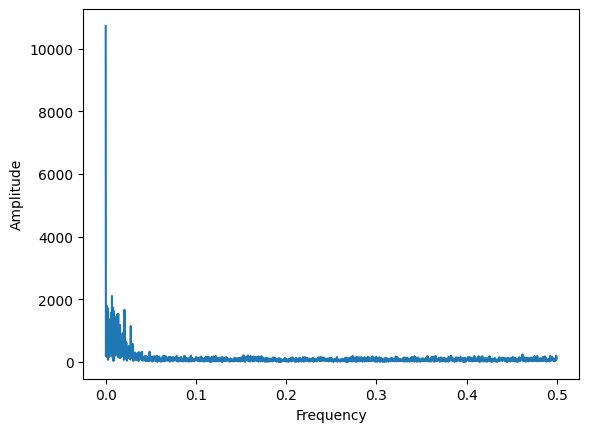

In [74]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
# Y    = np.fft.fft(np.array(jan_2020_smooth)[0:pickup_bins_len[0]])

Y    = np.fft.fft(np.array(months_smooth[0])[:pickup_bins_len[0]])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(pickup_bins_len[0], 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [75]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_base_year_smooth
# ratios_jan['Prediction']=jan_2020_smooth
ratios_jan['Prediction']=months_smooth[0]

ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [76]:
ratios_jan.shape

(308016, 3)

# 3. Modeling

## 3-1.Simple Moving Averages

In [77]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(max_pickup_bins_len*nyc_regions_cnt):
        if i%max_pickup_bins_len==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [78]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(max_pickup_bins_len*nyc_regions_cnt):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

## 3-2.Weighted Moving Averages

In [79]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(max_pickup_bins_len*nyc_regions_cnt):
        if i%max_pickup_bins_len==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [80]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(max_pickup_bins_len*nyc_regions_cnt):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

## 3-3.Exponential Weighted Moving Averages

In [81]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(max_pickup_bins_len*nyc_regions_cnt):
        if i%max_pickup_bins_len==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [82]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(max_pickup_bins_len*nyc_regions_cnt):
        if i%max_pickup_bins_len==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [83]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

# 4. Comparison between baseline models

In [84]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print (f"Moving Averages ({base_year+1} Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print (f"Weighted Moving Averages ({base_year+1} Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print (f"Exponential Moving Averages ({base_year+1} Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.414053082472783       MSE:  1343.5227358319048
Moving Averages (2020 Values) -                        MAPE:  0.20817227101943744        MSE:  51.7819950911641
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.4234893937298037       MSE:  1439.838297361176
Weighted Moving Averages (2020 Values) -               MAPE:  0.19630462407433022       MSE:  46.70650875279206
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.4385071746655818       MSE:  1345.1619396394992
Exponential Moving Averages (2020 Values) -         MAPE:  0.19748291715604

## Regression Models

### Regression Models

In [141]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2019= 24*31*60/10 = 4464      # pickup_bins_len[0]
# number of 10min indices for jan 2020 = 24*31*60/10 = 4464     # pickup_bins_len[0]
# number of 10min indices for feb 2020 = 24*29*60/10 = 4176     # pickup_bins_len[1]
# number of 10min indices for march 2020 = 24*31*60/10 = 4464   # pickup_bins_len[2]
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# print(len(regions_cum))
# 265
# print(len(regions_cum[0]))
# 4368


# we take number of pickups that are happened in last 5 intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 4368 for each cluster
# len(regions_cum[0]) == 4368
output = []

sum(pickup_bins_len[:base_month_count])
# 우리 데이터
# len(regions_cum[0]) - 5(:= # of colunms)
# 4368 - 5 = 4363
# 13104 - 5 = 13099

# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
# tsne_lat = []

# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
# tsne_lon = []

# 우리는 lat, lon 대신에 목적지 ID (PULocationID: 출발지, DOLocationID: 도착지)를 사용할 것이다.
tsne_PULocationID = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5, sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(1,nyc_regions_cnt+1):
    # tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099) # kmeans.cluster_centers_[i][0] := Coordinates of cluster centers. 클러스트 센터의 상관계수
    # tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)

    # tsne_PULocationID
    tsne_PULocationID.append([i]*(len(regions_cum[0]) - 5))


    day_of_the_week_dict = {2015: 4, 2016: 5, 2017: 1, 2018:1, 2019:2, 2020:3, 2021:5, 2022:6}
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    
    # jan 1st 2020 is tue -> 3
    tsne_weekday.append([int(((int(k/144))%7+day_of_the_week_dict[base_year])%7) for k in range(5,sum(pickup_bins_len[:base_month_count]))])

    # jan 1st 2021 is fri -> 5
    # tsne_weekday.append([int(((int(k/144))%7+5)%7) for k in range(5,sum(pickup_bins_len[:3]))])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    
    # 우리 데이터 
    # regions_cum [[x_1,x_2,...,x_{len(regions_cum[0]) - 5}],...265 lists] len(regions_cum[0]) - 5 = 4381
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i-1][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i-1])-number_of_time_stamps)]))
   
    output.append(regions_cum[i-1][5:])

tsne_feature = tsne_feature[1:]

In [86]:
print(tsne_feature.shape[0])
print(len(tsne_weekday)*len(tsne_weekday[0]))
print(len(output)*len(output[0]))
print(nyc_regions_cnt*(len(regions_cum[0])-5))
print(len(tsne_PULocationID)*len(tsne_PULocationID[0]))

307671
307671
307671
307671
307671


# Smoothing

In [87]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(1,nyc_regions_cnt+1):
    for i in range(0,len(regions_cum[0])):
        if i==0:
            predicted_value= regions_cum[r-1][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r-1][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [88]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region

sizeof_train_data = int((len(regions_cum[0])-5)*0.7)
sizeof_test_data = int((len(regions_cum[0])-5)*0.3)


print("size of train data :", sizeof_train_data)
print("size of test data :", sizeof_test_data)

size of train data : 3121
size of test data : 1337


In [89]:
# extracting first 91nyc_regions_cnt timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*(len(regions_cum[0])-5):((len(regions_cum[0])-5)*i+sizeof_train_data)] for i in range(0,nyc_regions_cnt)]

test_features = [tsne_feature[((len(regions_cum[0])-5)*(i))+sizeof_train_data:(len(regions_cum[0])-5)*(i+1)] for i in range(0,nyc_regions_cnt)]

In [90]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 69 Number of data points in trian data 3121 Each data point contains 5 features
Number of data clusters 69 Number of data points in test data 1338 Each data point contains 5 features


In [91]:
# extracting first sizeof_train_data timestamp values i.e 70% of 13099 (total timestamps) for our training data

tsne_train_flat_PULocationID = [i[:sizeof_train_data] for i in tsne_PULocationID]
tsne_train_flat_weekday = [i[:sizeof_train_data] for i in tsne_weekday]
tsne_train_flat_output = [i[:sizeof_train_data] for i in output]
tsne_train_flat_exp_avg = [i[:sizeof_train_data] for i in predict_list]

In [92]:
# extracting the rest of the timestamp values i.e 30% of sizeof_train_data + sizeof_test_data (total timestamps) for our test data

tsne_test_flat_PULocationID = [i[sizeof_train_data:] for i in tsne_PULocationID]
tsne_test_flat_weekday = [i[sizeof_train_data:] for i in tsne_weekday]
tsne_test_flat_output = [i[sizeof_train_data:] for i in output]
tsne_test_flat_exp_avg = [i[sizeof_train_data:] for i in predict_list]

In [93]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,nyc_regions_cnt):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,nyc_regions_cnt):
    test_new_features.extend(test_features[i])

In [94]:
tsne_train_PULocationID = sum(tsne_train_flat_PULocationID, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [95]:
tsne_test_PULocationID = sum(tsne_test_flat_PULocationID, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [96]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
# df_train['lat'] = tsne_train_lat
# df_train['lon'] = tsne_train_lon

df_train['PULocationID'] = tsne_train_PULocationID
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(215349, 8)


In [97]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
# df_test['lat'] = tsne_test_lat
# df_test['lon'] = tsne_test_lon

df_test['PULocationID'] = tsne_test_PULocationID
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(92322, 8)


In [98]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,PULocationID,weekday,exp_avg
0,1,1,1,3,3,1,2,2
1,1,1,3,3,3,1,2,2
2,1,3,3,3,4,1,2,3
3,3,3,3,4,2,1,2,2
4,3,3,4,2,2,1,2,2


In [99]:
print(df_test['PULocationID'].value_counts())
print(df_test['weekday'].value_counts())
print(df_test['exp_avg'].value_counts())

1     1338
45    1338
51    1338
50    1338
49    1338
      ... 
30    1338
31    1338
32    1338
33    1338
69    1338
Name: PULocationID, Length: 69, dtype: int64
3    19872
4    19872
2    12834
5     9936
6     9936
0     9936
1     9936
Name: weekday, dtype: int64
1      22665
2       7360
4       3694
5       3479
3       3354
       ...  
201        1
203        1
186        1
178        1
192        1
Name: exp_avg, Length: 197, dtype: int64


## Using Linear Regression

In [100]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# default paramters
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# some of methods of LinearRegression()
# fit(X, y[, sample_weight])	Fit linear model.
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict using the linear model
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# set_params(**params)	Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------

from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

## Using Random Forest Regressor

In [101]:
# Training a hyper-parameter tuned random forest regressor on our train data
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# -------------------------
# default paramters
# sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)

# some of methods of RandomForestRegressor()
# apply(X)	Apply trees in the forest to X, return leaf indices.
# decision_path(X)	Return the decision path in the forest
# fit(X, y[, sample_weight])	Build a forest of trees from the training set (X, y).
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict regression target for X.
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [102]:
# Predicting on test data using our trained random forest model 

# the models regr1 is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [103]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'PULocationID', 'weekday',
       'exp_avg'],
      dtype='object')
[0.0916934  0.07787566 0.15215029 0.18125811 0.26899257 0.00791333
 0.00289582 0.21722082]


## Using XgBoost Regressor

In [104]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBRegressor function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#module-xgboost.sklearn
# -------------------------
# default paramters
# xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
# booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
# colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
# missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=200, ...)

In [105]:
#predicting with our trained Xg-Boost regressor
# the models x_model is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [106]:
#feature importances
x_model.get_booster().get_score(importance_type="weight")

{'ft_5': 904.0,
 'ft_4': 823.0,
 'ft_3': 876.0,
 'ft_2': 966.0,
 'ft_1': 1112.0,
 'PULocationID': 1013.0,
 'weekday': 241.0,
 'exp_avg': 854.0}

## Calculating the error metric values for various models

In [107]:
train_R2=[]
test_R2=[]

train_R2.append(r2_score(tsne_train_output,df_train['ft_1'].values))
train_R2.append(r2_score(tsne_train_output,df_train['exp_avg'].values))
train_R2.append(r2_score(tsne_train_output,rndf_train_predictions))
train_R2.append(r2_score(tsne_train_output,xgb_train_predictions))
train_R2.append(r2_score(tsne_train_output,lr_train_predictions))

test_R2.append(r2_score(tsne_test_output,df_test['ft_1'].values))
test_R2.append(r2_score(tsne_test_output,df_test['exp_avg'].values))
test_R2.append(r2_score(tsne_test_output,rndf_test_predictions))
test_R2.append(r2_score(tsne_test_output,xgb_test_predictions))
test_R2.append(r2_score(tsne_test_output,lr_test_predictions))

In [108]:
print(f"{base_year+1} 1 ~ {base_month_count} {region} R2")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model\t\t\t","Train: ",train_R2[0],"Test: ",test_R2[0],sep='\t')
print ("Exponential Averages Forecasting","Train: ",train_R2[1],"Test: ",test_R2[1],sep='\t')
print ("Random Forest Regression\t","Train: ",train_R2[2],"Test: ",test_R2[2],sep='\t')
print ("XgBoost Regression\t\t","Train: ",train_R2[3],"Test: ",test_R2[3],sep='\t')
print ("Linear Regression\t\t","Train: ",train_R2[4],"Test: ",test_R2[4],sep='\t')

2020 1 ~ 1 Manhattan R2
--------------------------------------------------------------------------------------------------------
Baseline Model				Train: 	0.9160452960522986	Test: 	0.9202272307738298
Exponential Averages Forecasting	Train: 	0.925167857113413	Test: 	0.9294355208126309
Random Forest Regression		Train: 	0.9593941376941578	Test: 	0.9332827304584153
XgBoost Regression			Train: 	0.93340772834497	Test: 	0.9343531617507205
Linear Regression			Train: 	0.9270118460387383	Test: 	0.9315204579179917


In [109]:
train_MAE=[]
test_MAE=[]
train_MAE.append(mean_absolute_error(tsne_train_output,df_train['ft_1'].values))
train_MAE.append(mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))
train_MAE.append(mean_absolute_error(tsne_train_output,rndf_train_predictions))
train_MAE.append(mean_absolute_error(tsne_train_output,xgb_train_predictions))
train_MAE.append(mean_absolute_error(tsne_train_output,lr_train_predictions))

test_MAE.append(mean_absolute_error(tsne_test_output,df_test['ft_1'].values))
test_MAE.append(mean_absolute_error(tsne_test_output,df_test['exp_avg'].values))
test_MAE.append(mean_absolute_error(tsne_test_output,rndf_test_predictions))
test_MAE.append(mean_absolute_error(tsne_test_output,xgb_test_predictions))
test_MAE.append(mean_absolute_error(tsne_test_output,lr_test_predictions))

In [110]:
print(f"{base_year+1} 1 ~ {base_month_count} {region} MAE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model\t\t\t","Train: ",train_MAE[0],"Test: ",test_MAE[0],sep='\t')
print ("Exponential Averages Forecasting","Train: ",train_MAE[1],"Test: ",test_MAE[1],sep='\t')
print ("Random Forest Regression\t","Train: ",train_MAE[2],"Test: ",test_MAE[2],sep='\t')
print ("XgBoost Regression\t\t","Train: ",train_MAE[3],"Test: ",test_MAE[3],sep='\t')
print ("Linear Regression\t\t","Train: ",train_MAE[4],"Test: ",test_MAE[4],sep='\t')

2020 1 ~ 1 Manhattan MAE
--------------------------------------------------------------------------------------------------------
Baseline Model				Train: 	3.888845548388894	Test: 	4.037585840861333
Exponential Averages Forecasting	Train: 	3.6963812230379522	Test: 	3.8085613396590197
Random Forest Regression		Train: 	2.760602556779925	Test: 	3.748077381339226
XgBoost Regression			Train: 	3.5729211651783848	Test: 	3.721940599207123
Linear Regression			Train: 	3.6819024002897622	Test: 	3.779727475574619
